## Characterize usage of CloudLab

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import re
import hashlib
import time
import datetime as dt
from pandas.tseries.offsets import BDay
from matplotlib.lines import Line2D
import multiprocessing as mp
import calendar
from dateutil.relativedelta import relativedelta

%config InlineBackend.figure_format = 'retina'

# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None

source_dir = "data/"

if not os.path.isdir(source_dir):
    os.mkdir(dest_dir)
    
db = {}
for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f, low_memory=False)    
        
for k, df in db.iteritems():
    print "Table/dataframe: %s (Length: %d)" % (k, len(df))
    print "\t" + "\n\t".join(sorted(df.columns.tolist())), "\n"
    
%run graphics.ipynb

Table/dataframe: apt_reservation_history_actions (Length: 4850)
	action
	aggregate_urn
	idx
	reservation_uuid
	stamp 

Table/dataframe: apt_profiles (Length: 9015)
	gid_idx
	lastused
	listed
	locker_pid
	name
	name-hash
	pid_idx
	profileid
	project_write
	public
	topdog
	usecount
	uuid
	version 

Table/dataframe: used_hardware (Length: 593991)
	type
	uuid 

Table/dataframe: apt_instance_aggregate_history (Length: 116916)
	aggregate_urn
	name
	name-hash
	physnode_count
	retry_count
	status
	uuid
	virtnode_count 

Table/dataframe: apt_instance_failures (Length: 23642)
	created
	creator_idx
	creator_uuid
	exitcode
	exitmessage
	gid_idx
	logfileid
	name
	name-hash
	pid_idx
	profile_id
	profile_version
	slice_uuid
	start_at
	started
	uuid 

Table/dataframe: apt_reservation_history_details (Length: 3770)
	aggregate_urn
	approved
	end
	idx
	nodes
	pid_idx
	refused
	reservation_uuid
	stamp
	start
	type
	uid
	uid-hash
	uid_idx 

Table/dataframe: staff_hashes (Length: 6)
	uid
	uid-hash 

Table/d

## Process experiment information

In [2]:
stats = db["experiment_stats"]
resources = db["experiment_resources"]
nodes = db["nodes"]
node_h =  db["node_history"]

# Preprocess and join dataframes
    
print "Removing rows with resources.swapin_time==0"
resources = resources[resources.swapin_time > 0]
print "\nNumber of rows in resources:", len(resources)

experiments = pd.merge(stats, resources, on=["exptidx"], how="outer", indicator=True)
experiments = experiments[experiments._merge=="both"]
print "Number of rows in experiments:", len(experiments)

for c in ["swapin_time", "swapout_time", "swapmod_time", "created", "destroyed", "swapin_last", "swapout_last", "swapmod_last"]:
    try:
        experiments[c] = pd.to_datetime(experiments[c],unit='s')
    except:
        pass
    
for c in ["tstamp"]:
    try:
        experiments[c] = experiments[c].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    except:
        pass
        
for c in ["stamp"]:
    try:
        node_h[c] = pd.to_datetime(node_h[c],unit='s')
    except:
        pass
        
print "\nLatest swapin_time in experiments:", experiments.swapin_time.max()

nodes_unique = nodes[["node_id", "type"]]
nodes_unique = nodes_unique.drop_duplicates()
print "Number of unique node_id-type pairs:", len(nodes_unique)

nodes_merged = pd.merge(node_h, nodes_unique, on=["node_id"])

# Select Classic experiments:
classic = experiments[experiments.geniflags.isnull()]

#display(node_h.sample(5))
#display(classic.T)

print "Number of records in experiments:", len(experiments)
print "Number of records in classic:", len(classic)

# How many times nodes were allocated during specific period of time?

node_h[(node_h.exptidx.isin(classic.exptidx)) & (node_h.op=="alloc")]

nodes = nodes_merged

# Created dataframes:
#
# nodes -- dataframe with node history information with added "type" (hardware type) column coming from nodes table
# expertiments -- dataframe obtained by merging experiment_stats and experiment_resources (on exptidx)
# classic -- subset from experiments where experiments are created using the classic interface

Removing rows with resources.swapin_time==0

Number of rows in resources: 22500
Number of rows in experiments: 22498

Latest swapin_time in experiments: 2019-04-23 19:05:20
Number of unique node_id-type pairs: 3164
Number of records in experiments: 22498
Number of records in classic: 9164


In [3]:
history = db["apt_instance_history"]
agg_history = db["apt_instance_aggregate_history"]
failures = db["apt_instance_failures"]
profiles = db["apt_profiles"]
profile_versions = db["apt_profile_versions"]

# Preprocess and join dataframes

for c in ["created", "destroyed"]:
    try:
        history[c] = history[c].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    except: 
        pass
        
history["duration"] = (history["destroyed"] - history["created"]).apply(lambda x: x.total_seconds())

# Print lenghts and number of unique UUIDs
for t in ["apt_instance_history", "apt_instance_aggregate_history", 
          "apt_instance_failures", "apt_profiles", "apt_profile_versions"]:
    print "\nLength of \"%s\":" % t, len(db[t])
    if "uuid" in db[t].columns:
        print "\tNumber of unique UUIDs:", len(db[t]["uuid"].unique())
    
print "\nNumber of unique user names in apt_instance_history:", len(db["apt_instance_history"].creator_idx.unique())

# Keep failed experiments in the dataset for now
history_successful = history
agg_history_successful = agg_history

# Note: agg_history_successful includes multiple rows for the same UUID -- 
# individual records for each site used in multi-site experiments

# Merging history and agg_history
merged = history_successful.merge(agg_history_successful, 
                               on=["uuid", "name", "name-hash"], 
                               how='inner', indicator=True)
merged = merged[merged['_merge'] == "both"]

# print "Columns that preserve data from original tables (aren't merged):\n", \
# [x for x in merged.columns if "_x" in x or "_y" in x]

# display(merged.T)

print "\nLength of \"merged\" dataframe:", len(merged)

print "Sum of physical node counts:", merged["physnode_count_x"].sum()
print "Sum of virtual node counts:", merged["virtnode_count_x"].sum()
print "Time range based on created: %s -- %s" % (merged["created"].min(), merged["created"].max())
print "Number of unique UUIDs:", len(merged["uuid"].unique())
print "Number of unique names:", len(merged["name"].unique())

print "\nRemoving experiments with zero nodes"
print "Starting with number of records:", len(merged)  
zero_nodes = merged[(merged["physnode_count_x"] + merged["physnode_count_y"] + \
                     merged["virtnode_count_x"] + merged["virtnode_count_y"] == 0)]
print "Number of records with zero nodes:", len(zero_nodes)
print "Number of UUIds with zero nodes:", len(zero_nodes.uuid.unique())
    
merged = merged[~merged["uuid"].isin(zero_nodes["uuid"])] 
print "Number of records after filtering:", len(merged)
    
portal_all = merged   
print "\nNumber of records in portal_all:", len(portal_all)  

ly_start = portal_all["created"].max() - dt.timedelta(days=365)
portal_ly = merged[merged["created"] >= ly_start]
print "Number of records in portal_ly (all experiments created over last year):", len(portal_ly) 

# Created dataframes:
#
# portal_all -- all portal experiments (multiple records for each UUID for multi-site experiment)
# portal_ly  -- subset of experiments created over the last year


Length of "apt_instance_history": 112168
	Number of unique UUIDs: 112168

Length of "apt_instance_aggregate_history": 116916
	Number of unique UUIDs: 111289

Length of "apt_instance_failures": 23642
	Number of unique UUIDs: 23642

Length of "apt_profiles": 9015
	Number of unique UUIDs: 9015

Length of "apt_profile_versions": 31366
	Number of unique UUIDs: 31366

Number of unique user names in apt_instance_history: 4358

Length of "merged" dataframe: 116915
Sum of physical node counts: 355499
Sum of virtual node counts: 244738
Time range based on created: 2015-05-14 11:55:52 -- 2019-04-23 13:19:23
Number of unique UUIDs: 111288
Number of unique names: 77255

Removing experiments with zero nodes
Starting with number of records: 116915
Number of records with zero nodes: 22425
Number of UUIds with zero nodes: 19615
Number of records after filtering: 94489

Number of records in portal_all: 94489
Number of records in portal_ly (all experiments created over last year): 31685


In [4]:
used_hardware = db["used_hardware"]

# Merging portal_all (remove duplicate uuids to avoid multiple copies) and used_hardware to get node type usage
portal_all_with_hw = portal_all.drop_duplicates(["uuid"]).merge(used_hardware, on=["uuid"], how='inner')
print "Length of portal_all_with_hw:", len(portal_all_with_hw)

Length of portal_all_with_hw: 587429


## Process reservation information

Total number:  4850
reservation_uuid is NaN: 2229

action breakdown for all:
validate    2510
submit      1260
approve      687
delete       313
cancel        58
restore       22
Name: action, dtype: int64

action breakdown for reservation_uuid==NaN:
validate    2227
submit         2
Name: action, dtype: int64

reservation_uuid==NaN and action==submit:
                                aggregate_urn reservation_uuid  \
idx                                                              
407  urn:publicid:IDN+emulab.net+authority+cm              NaN   
408  urn:publicid:IDN+emulab.net+authority+cm              NaN   

                   stamp  action           timestamp  
idx                                                   
407  2018-03-09 15:37:03  submit 2018-03-09 15:37:03  
408  2018-03-09 15:37:15  submit 2018-03-09 15:37:15  

first and last timestamp for reservation_uuid==NaN:
2017-12-06 10:21:24 2019-04-23 11:41:42

The earliest reservation timestamp:  2017-12-06 10:21:24
The lates

,aggregate_urn,reservation_uuid,stamp,action,timestamp,site
idx,,,,,,
521,urn:publicid:IDN+emulab.net+authority+cm,NaN,2018-03-19 17:57:02,validate,2018-03-19 17:57:02,emulab
1162,urn:publicid:IDN+wisc.cloudlab.us+authority+cm,c36c9f17-4332-11e8-b7c3-5254000b4f72,2018-04-18 22:53:29,approve,2018-04-18 22:53:29,wisc
3873,urn:publicid:IDN+clemson.cloudlab.us+authority+cm,NaN,2019-01-25 08:17:55,validate,2019-01-25 08:17:55,clemson
2331,urn:publicid:IDN+emulab.net+authority+cm,ce41729f-ad9e-11e8-90d5-90e2ba22fee4,2018-08-31 22:39:54,validate,2018-08-31 22:39:54,emulab
1804,urn:publicid:IDN+emulab.net+authority+cm,8bfddcb0-585f-11e8-9817-90e2ba22fee4,2018-05-17 14:49:13,cancel,2018-05-17 14:49:13,emulab
1133,urn:publicid:IDN+emulab.net+authority+cm,NaN,2018-04-18 21:22:29,validate,2018-04-18 21:22:29,emulab
4323,urn:publicid:IDN+emulab.net+authority+cm,48714323-4cb5-11e9-910b-e4434b2381fc,2019-03-22 09:22:59,delete,2019-03-22 09:22:59,emulab
4450,urn:publicid:IDN+emulab.net+authority+cm,ba7f4874-531d-11e9-910b-e4434b2381fc,2019-04-01 08:42:33,approve,2019-04-01 08:42:33,emulab
3093,urn:publicid:IDN+wisc.cloudlab.us+authority+cm,NaN,2018-10-07 19:49:55,validate,2018-10-07 19:49:55,wisc


Sites in actions:
emulab     2614
wisc       1185
clemson     391
utah        346
apt         311
onelab        3
Name: site, dtype: int64


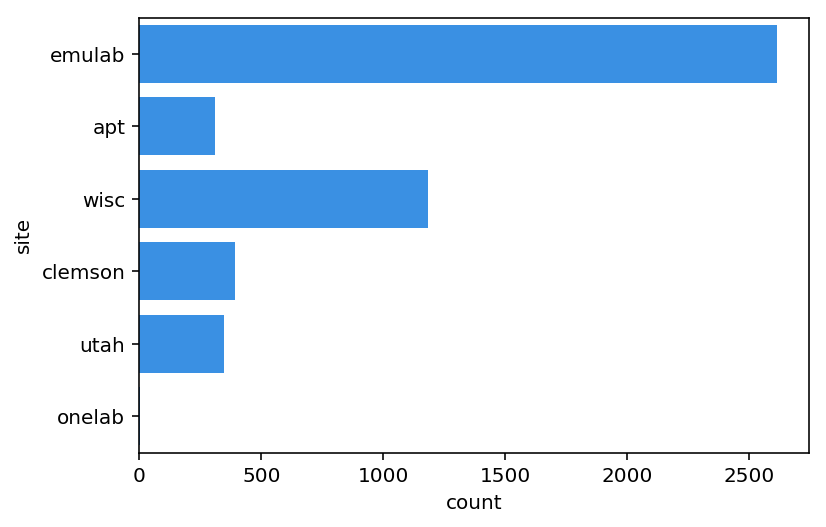

Total number:  3770
reservation_uuid is NaN: 2229

approved breakdown for reservation_uuid==NaN:
0    1865
1     364
Name: approved, dtype: int64

refused breakdown for reservation_uuid==NaN:
0    1373
1     856
Name: refused, dtype: int64

The earliest reservation timestamp:  2017-12-06 10:21:24
The latest reservation timestamp:  2019-04-23 11:42:37


idx,1465,2083,683,4604,1991,2036,964,2381,1577,4680
aggregate_urn,urn:publicid:IDN+clemson.cloudlab.us+authority+cm,urn:publicid:IDN+wisc.cloudlab.us+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+clemson.cloudlab.us+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+clemson.cloudlab.us+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+emulab.net+authority+cm
reservation_uuid,NaN,d39807a5-8156-11e8-9ebe-5254000b4f72,4ea6ff86-3685-11e8-a52e-90e2ba22fee4,NaN,NaN,NaN,NaN,NaN,NaN,5305f07a-5ec6-11e9-8006-e4434b2381fc
pid_idx,12930,13170,12777,13917,11534,11534,13763,11177,11534,10164
uid,4155F4AB9C,E806F313D6,939FEEE513,7B9761F6FE,B2EF3FEE90,B2EF3FEE90,E489E60448,FCB5CAEB26,B2EF3FEE90,03890E0F72
uid_idx,183476,241506,108388,241002,124301,124301,221738,181112,124301,292718
stamp,2018-04-26 16:17:36,2018-07-06 14:30:33,2018-04-02 08:51:22,2019-04-07 17:56:40,2018-06-23 15:59:40,2018-07-02 17:23:32,2018-04-13 13:53:42,2018-09-03 09:57:01,2018-04-30 15:45:34,2019-04-14 09:02:30
nodes,20,1,2,1,3,3,8,30,3,12
type,c6320,NaN,d430,c4130,d820,d820,c6320,d710,d820,d430
start,2018-04-27 08:00:00,2018-07-06 14:00:00,2018-04-02 12:00:00,2019-04-07 18:00:00,2018-06-24 01:00:00,2018-07-03 05:00:00,NaN,2018-09-03 12:00:00,2018-04-30 22:00:00,2019-04-14 14:00:00
end,2018-05-02 19:00:00,2018-07-09 14:00:00,2018-04-02 14:00:00,2019-04-07 21:00:00,2018-06-24 14:00:00,2018-07-03 14:00:00,2018-04-30 03:00:00,2018-09-15 08:00:00,2018-05-01 03:00:00,2019-04-14 16:00:00


Total number or rows in res dataframe:  4864

action breakdown for _merge==both:
validate    2498
submit      1258
Name: action, dtype: int64

action breakdown all:
validate    2510
submit      1260
approve      687
delete       313
cancel        58
restore       22
Name: action, dtype: int64
Starting with: 4864
After removing right_only (details but no action): 4850
After removing reservation_uuid==NaN and action==submit: 4848
After removing submit and validate without details: 4834
After removing actions without details with reservation_uuid==NaN: 4834

action breakdown res_filtered:
validate    2498
submit      1256
approve      687
delete       313
cancel        58
restore       22
Name: action, dtype: int64
Starting with: 4834
After removing staff: 4603

Unique users: 274
Unique projects: 171

Actions:
validate    2352
submit      1171
approve      687
delete       313
cancel        58
restore       22
Name: action, dtype: int64


,4224,4696,473,1492,2963
aggregate_urn,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+apt.emulab.net+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+emulab.net+authority+cm,urn:publicid:IDN+wisc.cloudlab.us+authority+cm
reservation_uuid,NaN,bbbc7cec-5cb5-11e9-88fc-021fd9d70c35,54e22ef4-2894-11e8-a52e-90e2ba22fee4,b1640c0b-4a66-11e8-a52e-90e2ba22fee4,NaN
stamp,2019-03-11 15:08:38,2019-04-15 10:04:24,2018-03-16 07:52:20,2018-04-27 16:02:37,2018-09-26 18:41:55
action,validate,delete,delete,submit,validate
timestamp,2019-03-11 15:08:38,2019-04-15 10:04:24,2018-03-16 07:52:20,2018-04-27 16:02:37,2018-09-26 18:41:55
site,emulab,apt,emulab,emulab,wisc
pid_idx,13208,NaN,NaN,11534,13891
uid,92AE50FE78,NaN,NaN,B2EF3FEE90,FA30C0CCC6
uid_idx,150009,NaN,NaN,124301,238681
nodes,1,NaN,NaN,3,1


In [5]:
# Process the reservations data that is in apt_reservation_history_actions and apt_reservation_history_details tables

def urn2site(s):
    for candidate in ["apt", "wisc", "clemson", "utah", "emulab", "onelab"]: 
        if candidate in s:
            return candidate
    print "Error: Can't identify site for: %s" % s
    return "unknown"

actions = db["apt_reservation_history_actions"]

# Use true index from database 
actions = actions.set_index('idx')
actions["timestamp"] = actions["stamp"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
print "Total number: ", len(actions)

actions_nan = actions[actions.reservation_uuid.isnull()]

print "reservation_uuid is NaN:", len(actions_nan)
print "\naction breakdown for all:\n", actions.action.value_counts()
print "\naction breakdown for reservation_uuid==NaN:\n", actions_nan.action.value_counts()
print "\nreservation_uuid==NaN and action==submit:\n", actions_nan[actions_nan["action"] == "submit"]
print "\nfirst and last timestamp for reservation_uuid==NaN:\n", actions_nan.stamp.min(), actions_nan.stamp.max()
print "\nThe earliest reservation timestamp: ", actions['timestamp'].min()
print "The latest reservation timestamp: ", actions['timestamp'].max()

actions["site"] = actions["aggregate_urn"].apply(urn2site)

display(actions.sample(10))

print "Sites in actions:\n", actions["site"].value_counts()
sns.countplot(y="site", data=actions, color="dodgerblue");
plt.show()

details = db["apt_reservation_history_details"]

# Use true index from database 
details = details.set_index('idx')
details["timestamp"] = details["stamp"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
print "Total number: ", len(details)

details_nan = details[details.reservation_uuid.isnull()]

print "reservation_uuid is NaN:", len(details_nan)
print "\napproved breakdown for reservation_uuid==NaN:\n", details_nan.approved.value_counts()
print "\nrefused breakdown for reservation_uuid==NaN:\n", details_nan.refused.value_counts()
print "\nThe earliest reservation timestamp: ", details['timestamp'].min()
print "The latest reservation timestamp: ", details['timestamp'].max()

details["site"] = details["aggregate_urn"].apply(urn2site)

display(details.sample(10).T)

# Actual preprocessing

# Combine actions and details into a single dataframe 
res = pd.merge(actions, details, on=["aggregate_urn", "reservation_uuid", "stamp", "timestamp", "site"], 
               how="outer", indicator=True)
print "Total number or rows in res dataframe: ", len(res)
#display(res.sample(10).T)

#print res._merge.value_counts()

print "\naction breakdown for _merge==both:\n", 
print res[res["_merge"] == "both"].action.value_counts()

print "\naction breakdown all:\n", 
print res.action.value_counts()

# Remove "strange", rare records (which potentially came from devel or inconsistencies)

print "Starting with:", len(res)

res_filtered = res[res["_merge"] != "right_only"]
print "After removing right_only (details but no action):", len(res_filtered)

res_filtered = res_filtered[~(res_filtered.reservation_uuid.isnull() & (res_filtered.action != "validate"))]
print "After removing reservation_uuid==NaN and action==submit:", len(res_filtered)

res_filtered = res_filtered[~((res_filtered._merge == "left_only") & ((res_filtered.action == "submit") | (res_filtered.action == "validate")))]
print "After removing submit and validate without details:", len(res_filtered)

res_filtered = res_filtered[~((res_filtered._merge == "left_only") & (res_filtered.reservation_uuid.isnull()))]
print "After removing actions without details with reservation_uuid==NaN:", len(res_filtered)

# Can't do this filterting!
# It completely removes actions like approve, delete, cancel, restore, etc
# filtered = filtered[~((filtered["start"].isnull()) | (filtered["end"].isnull()))]
# print "After removing actions without NaN in start or end:", len(filtered)

print "\naction breakdown res_filtered:\n", 
print res_filtered.action.value_counts()

# Removing staff

print "Starting with:", len(res_filtered)

res_filtered = res_filtered[~res_filtered["uid"].isin(db["staff_hashes"]["uid-hash"].tolist())]

print "After removing staff:", len(res_filtered)

for c in ["start", "end"]:
    try:
        res_filtered[c] = res_filtered[c].apply(lambda x: 
                                         dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if isinstance(x, basestring) else None)
    except:
        print "Column %s might be already converted"
res_filtered["duration"] = (res_filtered["end"] - res_filtered["start"]).apply(lambda x: x.total_seconds())
res_filtered["node-hours"] = res_filtered["nodes"] * res_filtered["duration"] / 3600.0

# From now on, use res for most of the analysis
res = res_filtered

print "\nUnique users:", len(res.uid_idx.unique())
print "Unique projects:", len(res.pid_idx.unique())

print "\nActions:\n", res.action.value_counts()

display(res.sample(5).T)

In [6]:
# Investigate actions without details

actions_no_details = pd.merge(actions, details, on=["aggregate_urn", "reservation_uuid", "stamp", "timestamp", "site"], how='left', indicator=True)
actions_no_details = actions_no_details[actions_no_details["_merge"] == "left_only"]

#display(actions_no_details.head(10))

print "\nThe earliest timestamp: ", actions_no_details['timestamp'].min()
print "The latest timestamp: ", actions_no_details['timestamp'].max()

print "Total number of actions_no_details:", len(actions_no_details)

print "\naction breakdown for actions_no_details:\n", actions_no_details.action.value_counts()

actions_no_details_nan = actions_no_details[actions_no_details.reservation_uuid.isnull()]
print "\nactions_no_details with reservation_uuid==NaN:", len(actions_no_details_nan)

# Summary:
# Most submit and validate actions have corresponding details; the ones that do not have them can be seen as outliers;
# almost all actions without details (approve, delete, etc.) have reservation_uuid's 
# (a few rare outliers do not have them)


The earliest timestamp:  2017-12-07 15:07:28
The latest timestamp:  2019-04-23 09:20:52
Total number of actions_no_details: 1094

action breakdown for actions_no_details:
approve     687
delete      313
cancel       58
restore      22
validate     12
submit        2
Name: action, dtype: int64

actions_no_details with reservation_uuid==NaN: 11


In [7]:
# Find unique sequences of actions (for the same reservations_uuid) and their frequencies
seqs = {}

for ruuid, grp in res.groupby(["reservation_uuid"]):
    seq = "-".join([str(x) for x in grp.sort_values("timestamp", ascending=True).action.tolist()])
    if seq not in seqs.keys():
        seqs[seq] = 1
    else:
        seqs[seq] += 1

pd.DataFrame([seqs]).T.sort_values(0, ascending=False).head(10)

,0
submit-approve,433
submit,222
submit-delete,152
submit-approve-delete,87
submit-approve-cancel,30
submit-approve-validate,22
submit-validate-submit-approve,22
approve-delete,11
submit-validate-submit-delete,8
delete,8


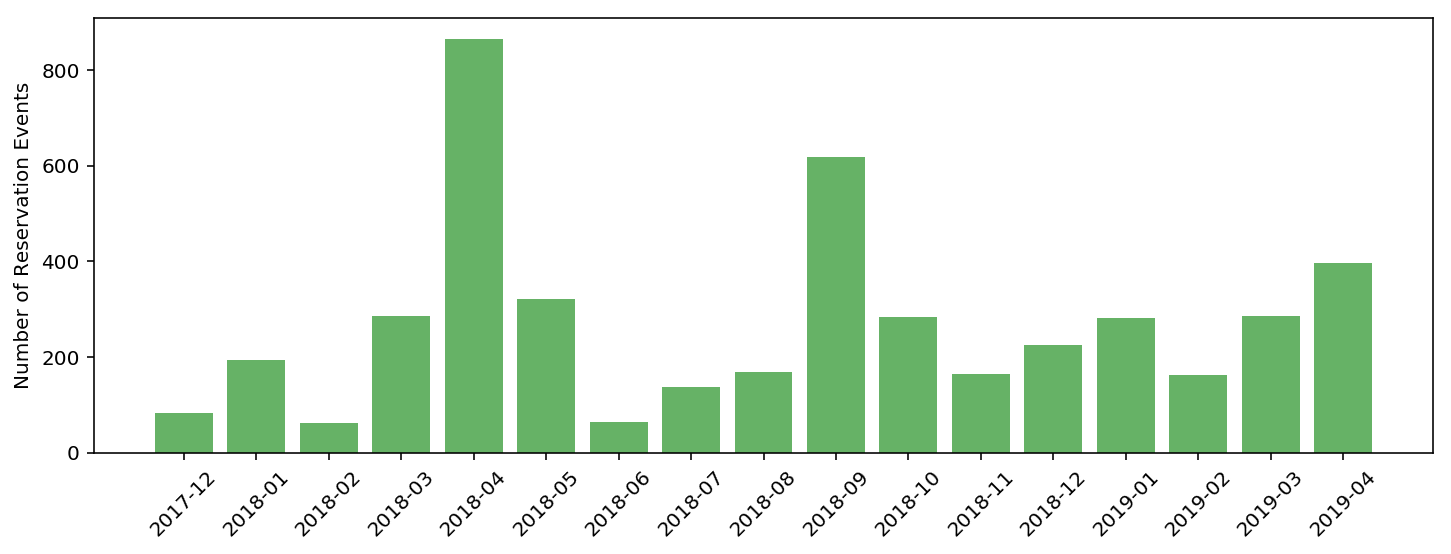

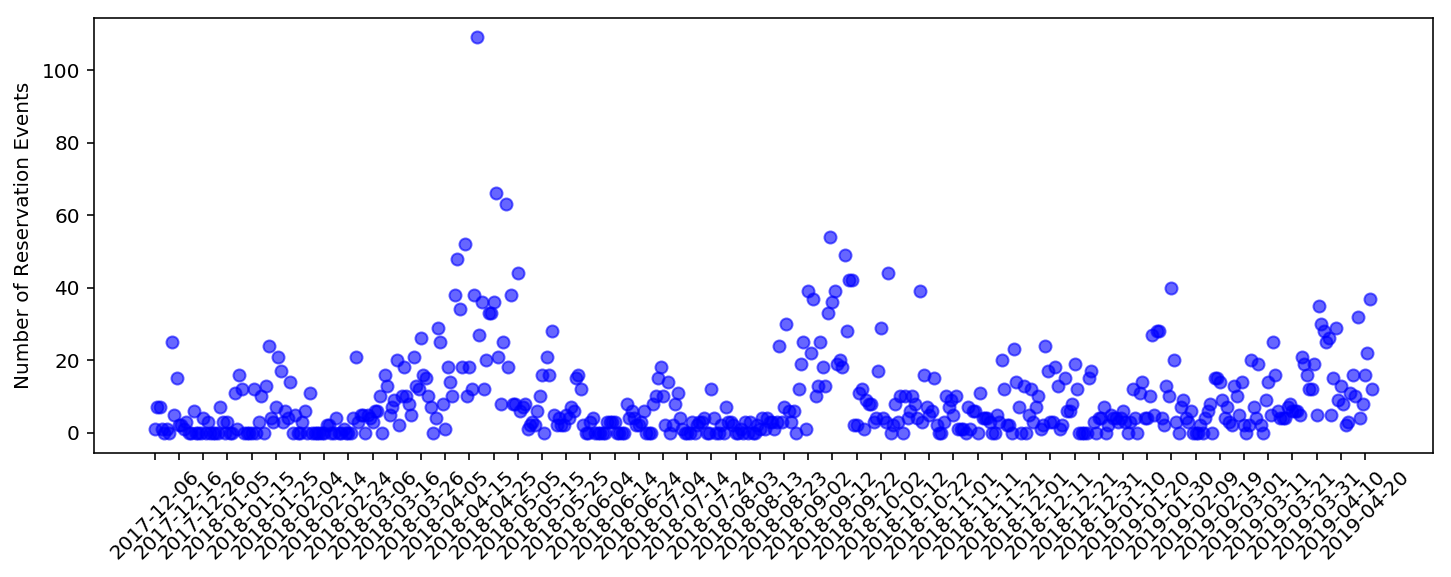

In [8]:
# Visualize number of performed actions per month

month_counts = pd.DataFrame(res.timestamp.dt.to_period('M').value_counts())
month_counts = month_counts.sort_index()
month_counts.columns = ["c"]

fig, ax = plt.subplots(figsize=(12, 4));

ax.bar(month_counts.index.to_series().astype(str), month_counts.c,
            color="green", alpha=0.6)

ax.set_ylabel("Number of Reservation Events")
plt.xticks(rotation=45);

# Visualize number of performed actions per day

day_counts = pd.DataFrame(res.timestamp.dt.to_period('D').value_counts())
day_counts = day_counts.sort_index()
day_counts.columns = ["c"]

day_counts.index = day_counts.index.to_series().astype(str)

recorded_days = day_counts.index.to_series().astype(str)

d1 = dt.date(*[int(x) for x in recorded_days[0].split("-")])  # start date
d2 = dt.date(*[int(x) for x in recorded_days[-1].split("-")]) # end date

delta = d2 - d1     
    
zeros = pd.DataFrame(0, index=[str(d1 + dt.timedelta(i)) for i in range(delta.days + 1)] , columns=["c"])

day_counts_all = day_counts.add(zeros, fill_value=0)
#day_counts_all

day_counts_all = day_counts_all.sort_index()

fig, ax = plt.subplots(figsize=(12, 4));

ax.scatter(day_counts_all.index, day_counts_all.c,
            color="blue", alpha=0.6)

ax.set_ylabel("Number of Reservation Events")
plt.xticks(rotation=45);

ax.xaxis.set_ticks(day_counts_all.index[0::10])
ax.xaxis.set_ticklabels(day_counts_all.index[0::10]);

,Validate count,Submit count
2017-12,44,20
2018-01,92,43
2018-02,32,17
2018-03,137,72
2018-04,450,202
2018-05,160,80
2018-06,35,17
2018-07,74,39
2018-08,80,46
2018-09,341,144


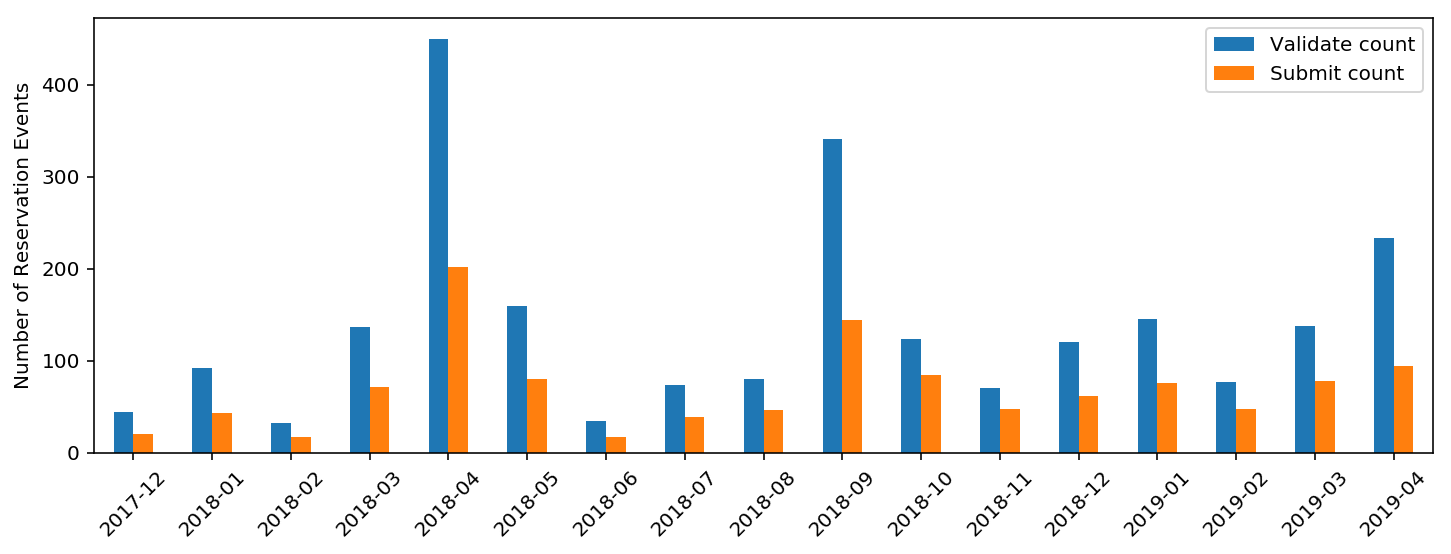

In [9]:
# Visualize number of performed actions per month

v_month_counts = pd.DataFrame(res[res.action=="validate"].timestamp.dt.to_period('M').value_counts())
v_month_counts = v_month_counts.sort_index()
v_month_counts.columns = ["Validate count"]
#v_month_counts["action"] = "v"

s_month_counts = pd.DataFrame(res[res.action=="submit"].timestamp.dt.to_period('M').value_counts())
s_month_counts = s_month_counts.sort_index()
s_month_counts.columns = ["Submit count"]
#s_month_counts["action"] = "s"

month_counts = v_month_counts.join(s_month_counts)
display(month_counts)

fig, ax = plt.subplots(figsize=(12, 4));

month_counts.plot(kind='bar', ax=ax)

ax.set_ylabel("Number of Reservation Events")
plt.xticks(rotation=45);

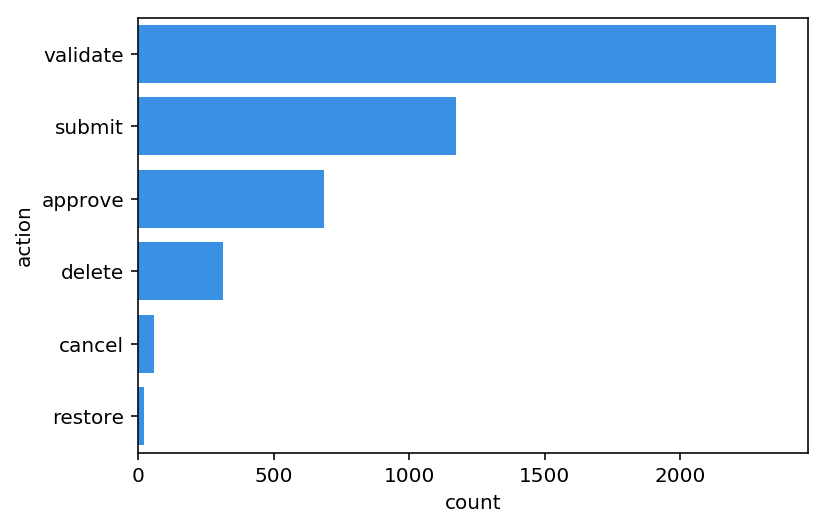

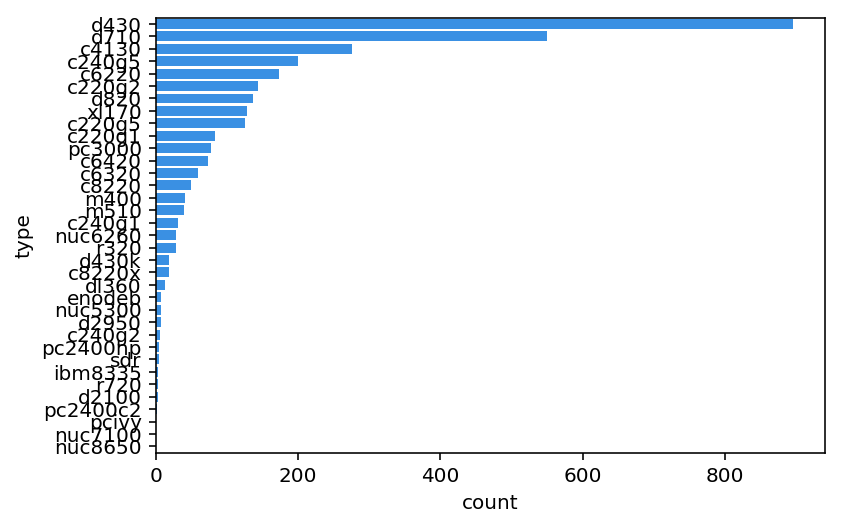

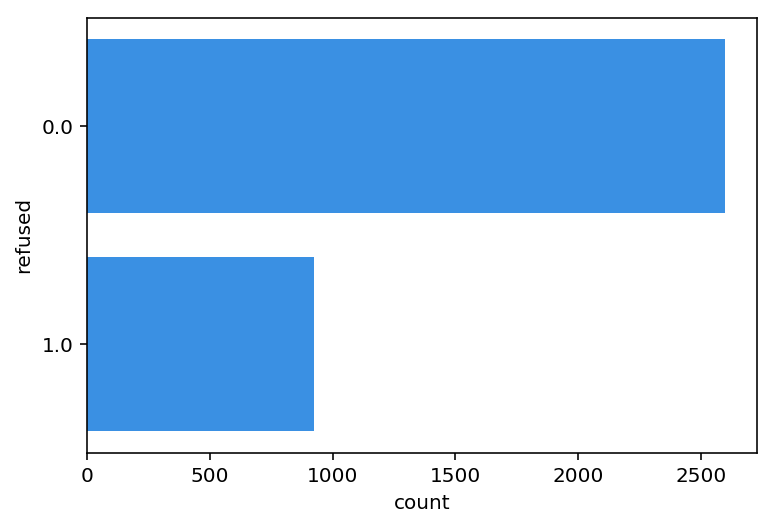

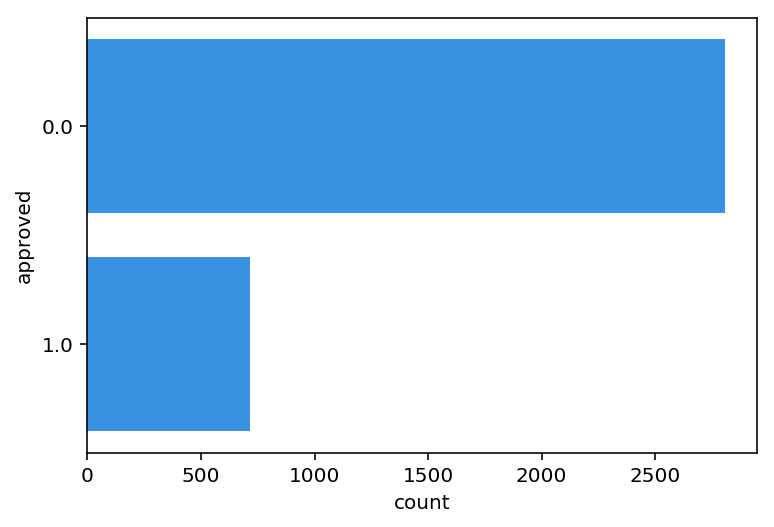

In [10]:
for c in ["action", "type", "refused", "approved"]:
    sns.countplot(y=c, data=res, color="dodgerblue", order = res[c].value_counts().index);    
    plt.show()

Total number: 1171


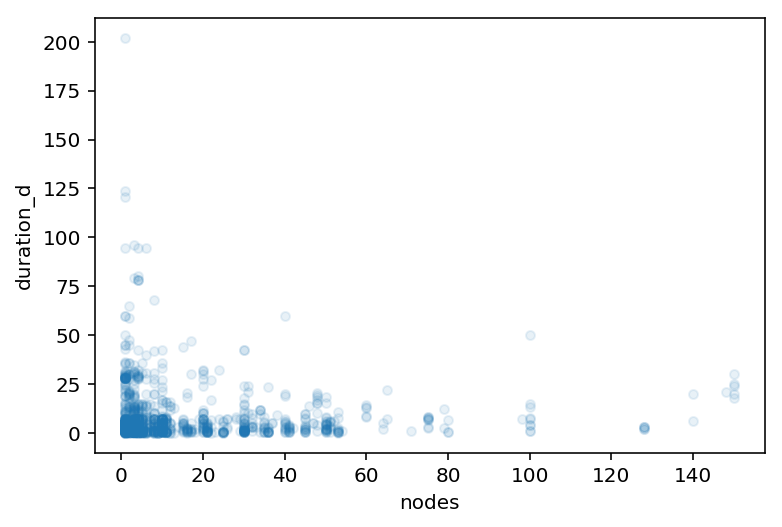

In [11]:
# Visualize both duration and number of nodes for submitted reservations

print "Total number:", len(res[res["action"] == "submit"])
res["duration_d"] = res["duration"] / (3600*24)
res[res["action"] == "submit"].plot.scatter(x="nodes", y="duration_d", alpha=0.1)
plt.show()

Starting with:
validate    2352
submit      1171
Name: action, dtype: int64

Reservations with largest validate counts:
73e8d9d3-4381-11e8-a52e-90e2ba22fee4    32
fd76123c-579d-11e9-8006-e4434b2381fc    16
e16aaa58-fbe4-11e8-815e-5254000b4f72    12
03b4b61d-0a0f-11e9-a23b-e4434b2381fc    11
4706cb28-3ebb-11e9-896c-5254000b4f72    11
75533a1e-4bbc-11e8-a52e-90e2ba22fee4    11
475615e9-426e-11e8-a52e-90e2ba22fee4    11
9742f31a-ba96-11e8-90d5-90e2ba22fee4    10
a906f474-4c95-11e8-a52e-90e2ba22fee4     9
b80fc2fe-a7cb-11e8-90d5-90e2ba22fee4     8
dtype: int64

Stats:
count    1078.000000
mean        1.609462
std         1.707100
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        32.000000
dtype: float64

How many validate actions preceed submits (in 10-minute windows)?:
Index is the number of validates and "cdf" is cumulative distribution function


,abs_freq,percent,cdf
0,14,1.298701,1.298701
1,781,72.448980,73.747681
2,143,13.265306,87.012987
3,55,5.102041,92.115028
4,34,3.153989,95.269017
5,19,1.762523,97.031540
6,14,1.298701,98.330241
7,7,0.649351,98.979592
8,2,0.185529,99.165121
9,1,0.092764,99.257885



Percent for >5:
2.9684601113172544


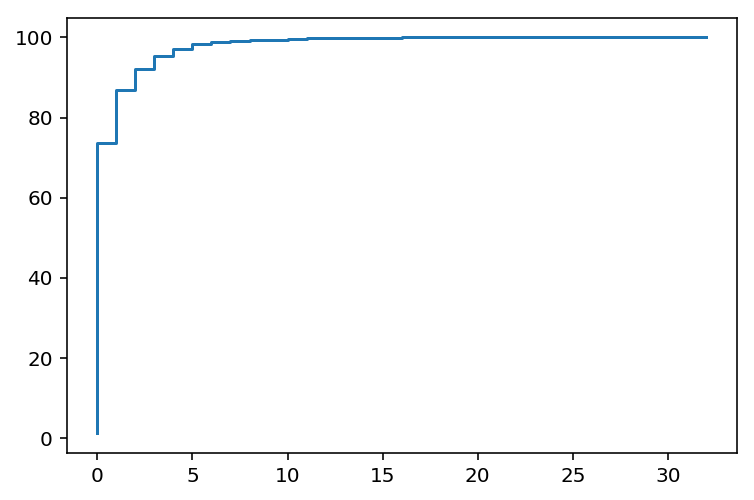


95th percentile: 4.0


In [12]:
# How many validates preceed submits?

# max period of time for cosidering events to be related, in minutes
delta_thresh = 10.0

validate_count = pd.Series()

v_and_s = res[res.action.isin(["submit","validate"])]
print "Starting with:\n", v_and_s.action.value_counts()

for uuid, grp in v_and_s.groupby(["uid"]):
    
    grp_c = grp.copy()
    grp_s = grp[grp.action=="submit"].copy()
    
    # Iterate over all user submits
    for idx, row in grp_s.iterrows():
        #print row
        
        window_end = row.timestamp
        window_start = row.timestamp - dt.timedelta(minutes=delta_thresh)
        
        e_in_window = grp_c[(grp_c.timestamp>=window_start) & (grp_c.timestamp<window_end)]
        
        if "submit" in e_in_window.action.tolist():
            # Find the latest submit
            preceeding_submit = e_in_window.loc[e_in_window[e_in_window.action == "submit"].timestamp.idxmax()]
            
            # Count validates after that submit
            #v_in_window = e_in_window[(e_in_window.timestamp>preceeding_submit.timestamp) & (grp_c.timestamp<window_end)]
            v_in_window = e_in_window[(e_in_window.timestamp>preceeding_submit.timestamp) & (e_in_window.timestamp<window_end)]
        
            validate_count.loc[row.reservation_uuid] = len(v_in_window)
        else:
            # Simple case: only validates found in the time window
            validate_count.loc[row.reservation_uuid] = len(e_in_window)

print "\nReservations with largest validate counts:\n", validate_count.sort_values(ascending=False)[:10]
print "\nStats:\n", validate_count.describe()

print "\nHow many validate actions preceed submits (in %d-minute windows)?:" % int(delta_thresh)
print "Index is the number of validates and \"cdf\" is cumulative distribution function"

v_cdf = pd.DataFrame(validate_count.value_counts())
v_cdf.columns = ["abs_freq"]

v_cdf["percent"]= v_cdf.abs_freq / v_cdf.abs_freq.sum() * 100.0
v_cdf.sort_index(inplace=True)
v_cdf["cdf"] = v_cdf["percent"].cumsum() 
display(v_cdf)

print "\nPercent for >5:\n", v_cdf[v_cdf.index>5].percent.sum()

plt.step(v_cdf.index, v_cdf.cdf)
plt.show()

print "\n95th percentile:", validate_count.quantile(.95)

## Show utilization stats and plots

Number of records: 587429
Number of UUIDs: 90417
The earliest created timestamp: 2015-05-14 11:55:52
The latest destroyed timestamp: 2019-04-23 13:49:32
Breakdown by hardware_type:

,vm,m400,m510,r320,c8220,c220g2,d430,c6320,c220g1,xl170,...,x310,c240g1,nuc7100,nuc8559,m510,d840,pc2400w,faros-sfp,c8220-vm,C220M4-vm
type,233123,47406,44976,38401,37678,26562,24172,19682,19237,18862,...,5,4,3,3,2,2,1,1,1,1


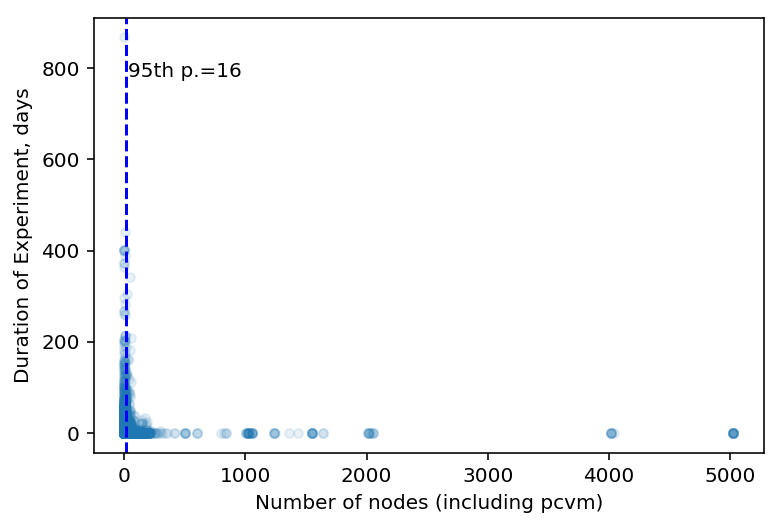

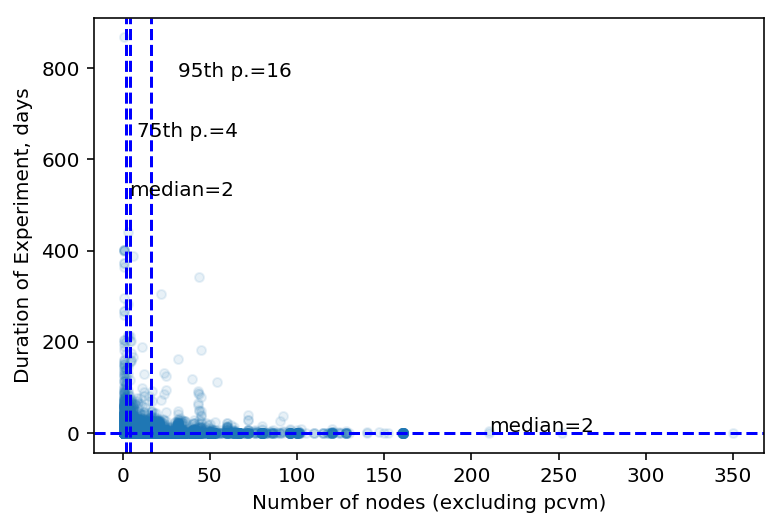

In [13]:
# Show some stats and plots from portal_all_with_hw

print "Number of records:", len(portal_all_with_hw)
print "Number of UUIDs:", len(portal_all_with_hw.uuid.unique())
print "The earliest created timestamp:", portal_all_with_hw['created'].min()
print "The latest destroyed timestamp:", portal_all_with_hw['destroyed'].max()

print "Breakdown by hardware_type:", 
display(pd.DataFrame(portal_all_with_hw.type.value_counts()).T)

# Plots in duration-count coordinates 

# With pcvm

fig, ax = plt.subplots(figsize=(6,4))
usage = portal_all_with_hw.groupby(["uuid"])['duration'].agg(['count', 'first'])
usage["duration_d"] = usage["first"] / (3600*24)
usage.plot.scatter(x="count", y="duration_d", alpha=0.1, logx=False, ax=ax)

nodes_95p = usage["count"].quantile(0.95)
ax.annotate('95th p.=%d' % nodes_95p, xy=(0,0),
                  xytext=(nodes_95p * 2.0, usage["duration_d"].max() * 0.9))
ax.axvline(nodes_95p, linestyle="--", c="blue")

ax.set_ylabel("Duration of Experiment, days")
ax.set_xlabel("Number of nodes (including pcvm)")
plt.show()

# Without vm and pcvm (VMs and docker nodes)

fig, ax = plt.subplots(figsize=(6,4))
usage = portal_all_with_hw[(portal_all_with_hw["type"] != "pcvm") & \
                           (portal_all_with_hw["type"] != "vm")\
                          ].groupby(["uuid"])['duration'].agg(['count', 'first'])
usage["duration_d"] = usage["first"] / (3600*24)
usage.plot.scatter(x="count", y="duration_d", alpha=0.1, logx=False, ax = ax)

nodes_med = usage["count"].median()
ax.annotate('median=%d' % nodes_med, xy=(0,0),
                  xytext=(nodes_med * 2.0, usage["duration_d"].max() * 0.6))
ax.axvline(x=nodes_med, linestyle="--", c="blue")

nodes_75p = usage["count"].quantile(0.75)
ax.annotate('75th p.=%d' % nodes_75p, xy=(0,0),
                  xytext=(nodes_75p * 2.0, usage["duration_d"].max() * 0.75))
ax.axvline(nodes_75p, linestyle="--", c="blue")

nodes_95p = usage["count"].quantile(0.95)
ax.annotate('95th p.=%d' % nodes_95p, xy=(0,0),
                  xytext=(nodes_95p * 2.0, usage["duration_d"].max() * 0.9))
ax.axvline(nodes_95p, linestyle="--", c="blue")

duration_d_med = usage["duration_d"].median()
ax.annotate('median=%d' % nodes_med, xy=(0,0),
                  xytext=(usage["count"].max() * 0.6, duration_d_med * 4.0))
ax.axhline(y=duration_d_med, linestyle="--", c="blue")

ax.set_ylabel("Duration of Experiment, days")
ax.set_xlabel("Number of nodes (excluding pcvm)")
plt.show()

In [14]:
# Get hw inception times, node counts, and major types

hw_inception = db["nodes"][["type", "inception"]]
hw_inception = hw_inception.groupby("type").agg(min)
hw_inception = hw_inception[~hw_inception["inception"].isna()]

node_counts = pd.DataFrame(db["nodes"].type.value_counts())
node_counts.columns = ["count"]
node_counts = pd.merge(node_counts, hw_inception, left_index=True, right_index=True)
#display(node_counts.T)

major_types = node_counts[(node_counts["count"] > 65) & (node_counts.index != "pcvm")]
display(major_types.T)

,m400,m510,c220g5,xl170,c220g2,d710,d430,pc3000,r320,c8220,c220g1,c6320,c6420
count,315,270,224,200,163,161,160,157,128,96,90,84,72
inception,2014-11-22 22:39:51,2016-04-29 15:36:32,2018-02-17 22:33:33,2018-01-25 19:19:30,2016-03-11 02:34:39,2009-08-18 09:21:49,2016-01-12 20:50:21,2005-08-03 10:10:39,2014-05-24 20:30:48,2015-03-30 14:23:52,2016-04-15 13:20:23,2016-03-24 10:00:05,2018-03-23 17:47:36


In [15]:
portal_all_with_hw_major = portal_all_with_hw[portal_all_with_hw["type"].isin(major_types.index)]
print "Length of portal_all_with_hw for major types:", len(portal_all_with_hw_major)

Length of portal_all_with_hw for major types: 321163


In [16]:
# For classic experiments, do additional processing:
# for each node, find every alloc and the op's immediately following them; 
# create a new dataframe with these timestamps

print "Length of dataframe with all ops:", len(nodes)
print "Number of allocs:", len(nodes[nodes=="alloc"])
print "Number of unique_nodes:", len(nodes.node_id.unique())

exptidx2pid = experiments[["exptidx", "pid_idx"]]
exptidx2pid = exptidx2pid.drop_duplicates()
     
# Add pid column to node dataframe
nodes_with_pid = pd.merge(nodes, exptidx2pid, on=["exptidx"], how="outer")
#display(nodes_with_pid.sample(10))

nodes_allocs = pd.DataFrame()

print "Processing all nodes:"
for idx, (node_id, grp) in enumerate(nodes_with_pid.groupby("node_id")):
    
    gs = grp.sort_values("stamp")
    gs["following_stamp"] = gs["stamp"].shift(-1)
    gs["duration"] = gs["following_stamp"]-gs["stamp"]
    # Change the last value from NaT to current timestamp
    gs.loc[gs.index[-1], "following_stamp"] = dt.datetime.now()
    
    nodes_allocs = nodes_allocs.append(gs[gs.op=="alloc"])
    
    sys.stdout.write(".")
    if not ((idx + 1) % 80):
        sys.stdout.write("\n")
    sys.stdout.flush()
    
display(nodes_allocs.sample(5))
print "Length of dataframe with all allocs:", len(nodes_allocs)

print "pid is NaN:", len(nodes_allocs[nodes_allocs.pid_idx.isnull()])

# Summary:
# nodes_allocs -- dataframe with allocs for specific nodes; include such columns as pid, following_stamp;
#   the latter is the timestamp of the following operation recorded for the same node 
#   (usually recorded under different pid); constructing this dataframe speeds up processing in the following steps

Length of dataframe with all ops: 511060
Number of allocs: 511060
Number of unique_nodes: 588
Processing all nodes:
................................................................................
................................................................................
................................................................................
................................................................................
................................................................................
................................................................................
................................................................................
............................

,history_id,node_id,op,uid,uid_idx,exptidx,stamp,cnet_IP,cnet_mac,phys_nodeid,type,pid_idx,following_stamp,duration
398254,8009105.0,pc485,alloc,lefort_a,224064.0,384314,2018-11-19 08:10:13,NaN,NaN,NaN,d710,13444.0,2018-11-21 00:20:14,1 days 16:10:01
467326,7614415.0,pc706,alloc,stoller,282.0,354978,2018-01-10 13:28:24,NaN,NaN,NaN,d430,10345.0,2018-01-10 14:53:26,0 days 01:25:02
395621,7927193.0,pc203,alloc,paolamp,168270.0,381924,2018-09-03 12:06:11,NaN,NaN,NaN,pc3000,13388.0,2018-09-03 15:50:32,0 days 03:44:21
506033,7809092.0,pc609,alloc,llb0189,69592.0,376357,2018-04-27 11:05:16,NaN,NaN,NaN,d820,12270.0,2018-04-28 03:04:48,0 days 15:59:32
459431,7833827.0,pc859,alloc,wangm12,187530.0,354575,2018-05-18 22:16:59,NaN,NaN,NaN,d430,11241.0,2018-05-23 22:47:37,5 days 00:30:38


Length of dataframe with all allocs: 125482
pid is NaN: 1552


Processing node type: m400
Processing node type: m510
Processing node type: c220g5
Processing node type: xl170
Processing node type: c220g2
Processing node type: d710
Processing node type: d430
Processing node type: pc3000
Processing node type: r320
Processing node type: c8220
Processing node type: c220g1
Processing node type: c6320
Processing node type: c6420


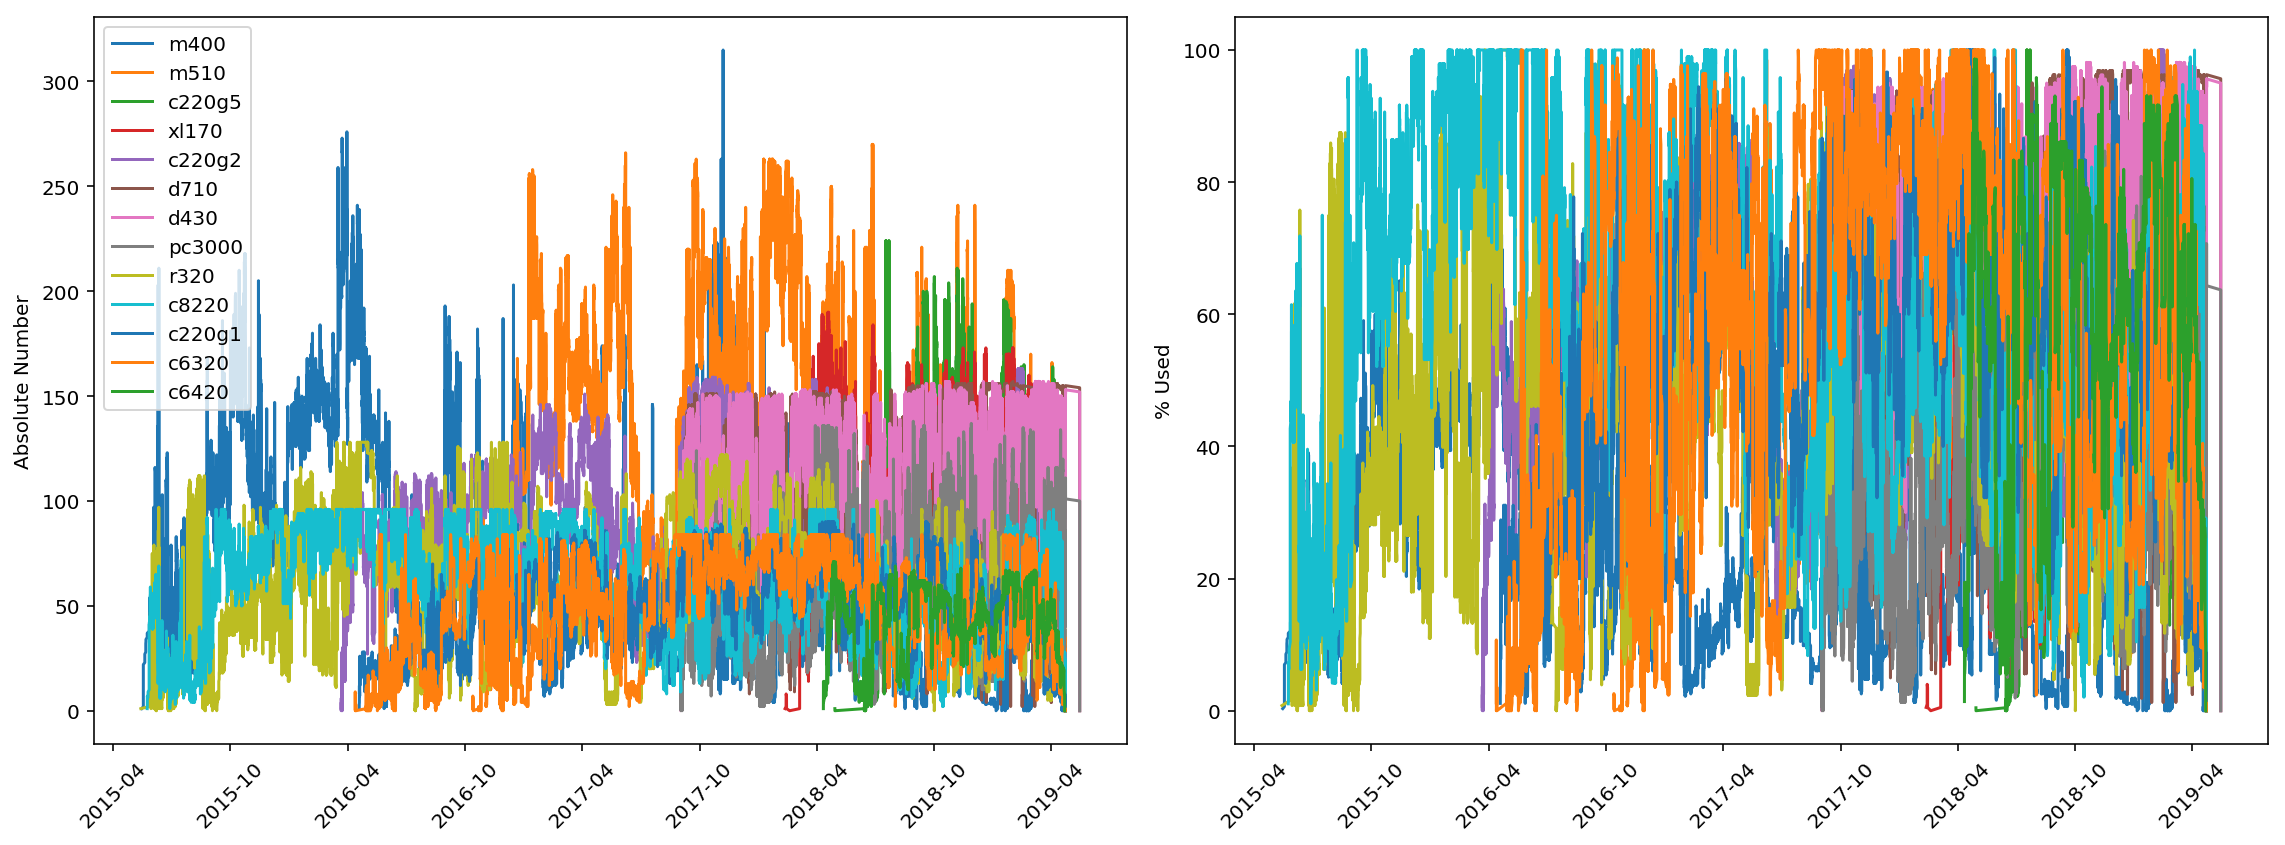

In [17]:
# Reconstruct and visualize node usage timelines for major hardware types

# Dict where keys are hardware types and values are corresponding timeline dataframe
all_timelines = {}

isBusinessDay = BDay().onOffset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6));

#for hw_type in total_count_major.keys():
for hw_type in major_types.index:
    
    print "Processing node type:", hw_type
    
    created_df = pd.DataFrame()
    destroyed_df = pd.DataFrame()

    # Process classic    
    selected_nodes_classic = nodes_allocs[nodes_allocs.type == hw_type]
    #print "Node type: %s, classic total number: %d" % (hw_type, len(selected_nodes_classic))
    created_df = pd.concat([created_df, 
                           pd.DataFrame(selected_nodes_classic.stamp.tolist(), columns=["timestamp"])])
    destroyed_df = pd.concat([destroyed_df, 
                             pd.DataFrame(selected_nodes_classic.following_stamp.tolist(), columns=["timestamp"])])

    # Process portal
    if hw_type not in ["pc3000", "d430", "d710"]:
        selected_nodes_portal = portal_all_with_hw_major[portal_all_with_hw_major["type"] == hw_type]
        #print "Node type: %s, portal total number: %d" % (hw_type, len(selected_nodes_portal))
        created_df = pd.concat([created_df, 
                               pd.DataFrame(selected_nodes_portal["created"].tolist(), columns=["timestamp"])])
        destroyed_df = pd.concat([destroyed_df, 
                                 pd.DataFrame(selected_nodes_portal["destroyed"].tolist(), columns=["timestamp"])])
        
    created_df["delta"] = 1
    destroyed_df["delta"] = -1
        
    timeline_df = pd.concat([created_df, destroyed_df]).sort_values("timestamp")
    timeline_df["total"] = timeline_df["delta"].cumsum()
    
    timeline_df["day"] = timeline_df["timestamp"].dt.to_period('D')
    timeline_df["business_day"] = timeline_df.timestamp.map(isBusinessDay)

    total_count = major_types.loc[hw_type]["count"]
    
    timeline_df.loc[timeline_df["total"] > total_count, "total"] = total_count
    timeline_df.loc[timeline_df["total"] < 0, "total"] = 0
    
    timeline_df['duration'] = timeline_df["timestamp"].diff().shift(-1).apply(lambda x: x.total_seconds())
    
    timeline_df["avail"] = timeline_df["total"] * (-1) + total_count
        
    # Preserve each timeline for further processing
    all_timelines[hw_type] = timeline_df 

    ax1.plot(timeline_df["timestamp"], timeline_df['total'], label=hw_type)
    ax2.plot(timeline_df["timestamp"], timeline_df['total'] * 100.0 / total_count, label=hw_type)

ax1.legend()
ax1.set_ylabel("Absolute Number")
ax2.set_ylabel("% Used")
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.tight_layout()

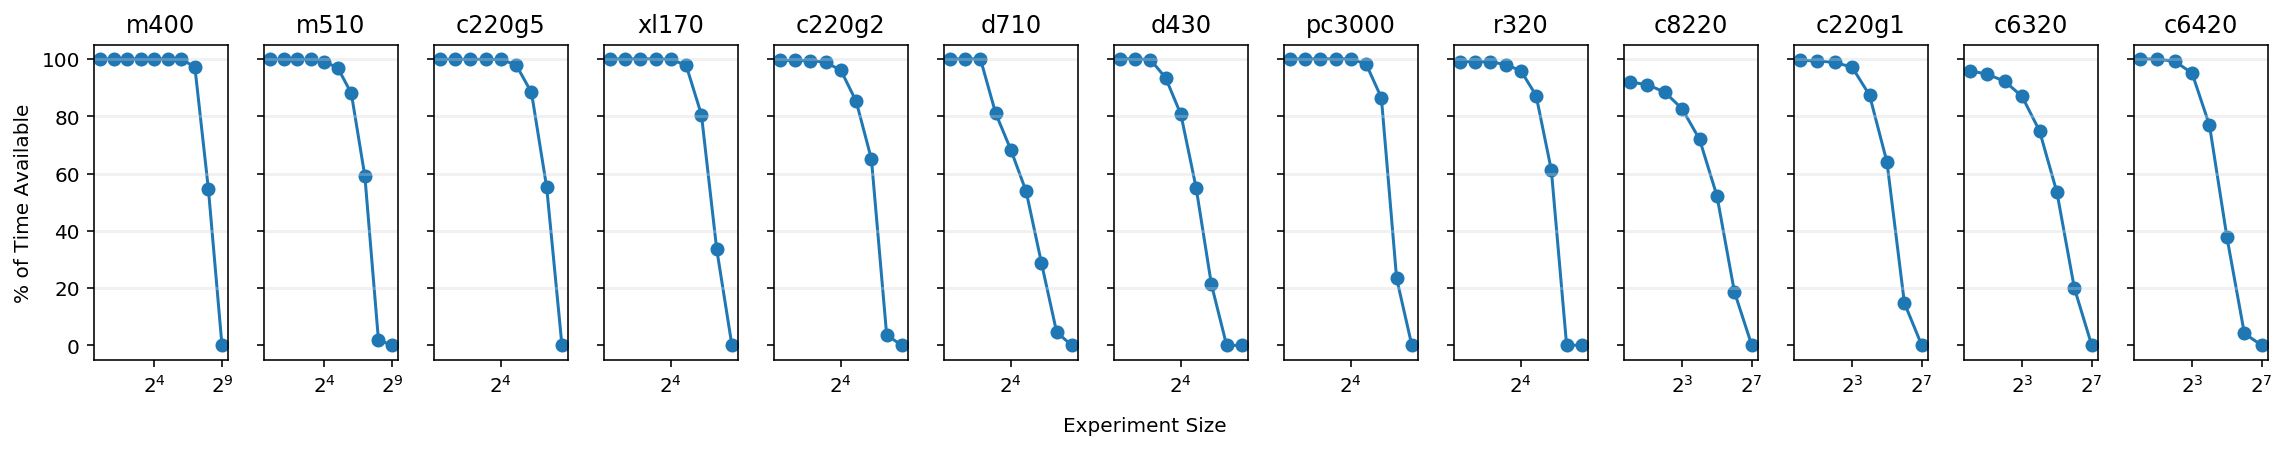

In [18]:
# % of time available for an experiment of a given size

def avail_time_above_thresh(df, thresh):
    return df[df["avail"] >= thresh]["duration"].sum()   

fig, axes = plt.subplots(1, len(major_types), sharey=True, figsize=(16, 3));
plt.subplots_adjust(hspace=0)

#for hw_type, ax in zip(total_count_major.keys(), axes):
for hw_type, ax in zip(major_types.index, axes):

    timeline_df = all_timelines[hw_type]
    total_count = major_types.loc[hw_type]["count"]
    
    # Fix negative, if present
    #timeline_df["avail"][timeline_df["avail"] < 0] = 0
    
    total_duration = (timeline_df["timestamp"].max() - timeline_df["timestamp"].min()).total_seconds()
    
    x_vals = [2 ** p for p in range(int(np.log2(total_count)) + 2)]
    y_vals = [avail_time_above_thresh(timeline_df, x) / total_duration * 100.0 for x in x_vals]
    
    ax.plot(x_vals, y_vals,'-o')
    
    ax.set_title(hw_type)
    ax.set_xscale('log', basex=2)
    
    for x in np.arange(5):
        ax.axhline(20 * (x + 1), color="lightgray", alpha=0.3)
    
axes[0].set_ylabel("% of Time Available")
fig.text(0.5, -0.02, 'Experiment Size', ha='center')

plt.tight_layout()

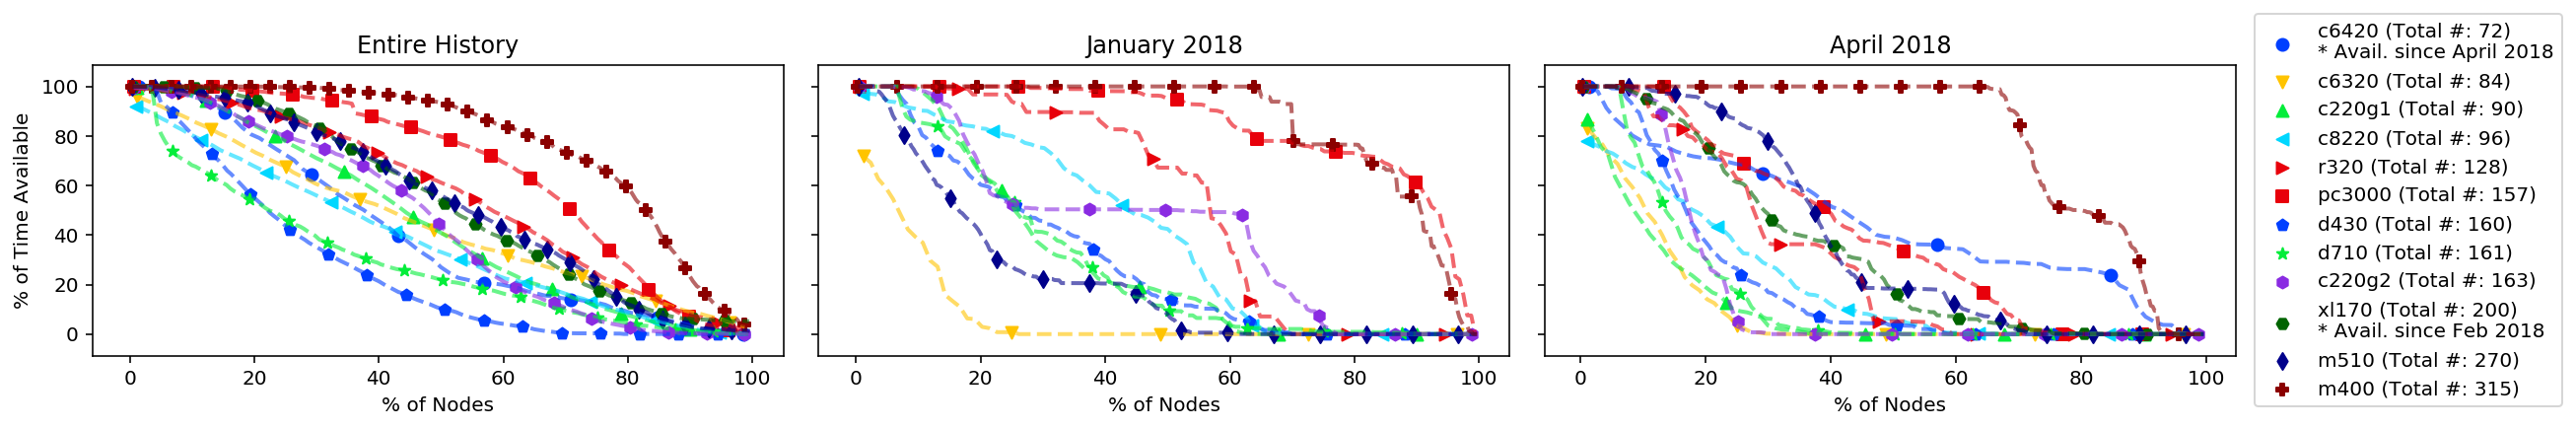

In [19]:
# Combine three plots

marker_list = Line2D.filled_markers
marker_list = [x for x in marker_list if x != "8"]
#print marker_list

# Assign markers in the order of increasing node count
type_marker = {hw:marker_list[idx % len(marker_list)] 
                for idx, hw in enumerate(major_types.sort_values("count", ascending=True).index)}

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 3));

ax = axes[0]
plt.subplots_adjust(hspace=0)

marker_idx = 0
for hw_type in major_types.sort_values("count", ascending=True).index:

    total_count = major_types.loc[hw_type]["count"]
    
    # Skip c240g5 -- too new (avail after: 2018-06-13 15:08:42)
    if hw_type == "c240g5":
        continue
    if hw_type == "c220g5":
        continue

    timeline_df = all_timelines[hw_type]
    
    total_duration = (timeline_df["timestamp"].max() - timeline_df["timestamp"].min()).total_seconds()
     
    x_vals = range(1, total_count)
    y_vals = [avail_time_above_thresh(timeline_df, x) / total_duration * 100.0 for x in x_vals]
    x_vals = np.array(x_vals) / float(total_count) * 100
    
    ax.plot(x_vals, y_vals, '--', lw=2, alpha=0.6, c = type_cmap[hw_type])
    
    ax.scatter(x_vals[0::10], y_vals[0::10], marker=type_marker[hw_type], 
               c = type_cmap[hw_type], label=hw_type)
        
    marker_idx += 1

ax.set_ylabel("% of Time Available")
ax.set_xlabel("% of Nodes")
ax.set_title("Entire History")

# Add figures for specific months on the same plot 

for limits, ax in zip([["2018-01-01", "2018-02-01"], ["2018-04-01", "2018-05-01"]], axes[1:]):

    (p_start, p_end) = limits
    
    for hw_type in major_types.sort_values("count", ascending=True).index:
        
        total_count = major_types.loc[hw_type]["count"]
    
        # Skip types that weren't available in January
        if p_end == "2018-02-01" and hw_type in ["xl170", "c6420"]:
            continue
    
        # Skip types that weren't available
        if hw_type in ["c240g5", "c220g5"]:
            continue
        
        timeline_df = all_timelines[hw_type]

        if "avail" not in timeline_df.columns: 
            timeline_df["avail"] = timeline_df["total"] * (-1) + total_count
            
        # Select specific period
        selected_period = timeline_df[(timeline_df["timestamp"] 
                                       >= dt.datetime.strptime("%s 00:00:00" % p_start, "%Y-%m-%d %H:%M:%S")) & 
                                       (timeline_df["timestamp"] 
                                        <= dt.datetime.strptime("%s 00:00:00" % p_end, "%Y-%m-%d %H:%M:%S"))]

        selected_period["duration"] = selected_period["timestamp"
                                                     ].diff().shift(-1).apply(lambda x: x.total_seconds()).fillna(0)
         
        total_duration = (selected_period["timestamp"].max() - selected_period["timestamp"].min()).total_seconds()

        x_vals = range(1, total_count)
        y_vals = [avail_time_above_thresh(selected_period, x) / total_duration * 100.0 for x in x_vals]
        x_vals = np.array(x_vals) / float(total_count) * 100
        y_vals = pd.to_numeric(pd.Series(y_vals).fillna(0)).tolist()
        
        ax.plot(x_vals, y_vals, '--', lw=2, alpha=0.6, c = type_cmap[hw_type])
           
        if hw_type == "xl170":
            l = hw_type + " (Total #: %d)" % total_count + "\n* Avail. since Feb 2018"
        elif hw_type == "c6420":
            l = hw_type + " (Total #: %d)" % total_count + "\n* Avail. since April 2018"
        else:
            l = hw_type + " (Total #: %d)" % total_count
            
        ax.scatter(x_vals[0::20], y_vals[0::20], 
                   marker=type_marker[hw_type], c = type_cmap[hw_type], 
                   label= l)
        
    ax.set_xlabel("% of Nodes")
    ax.set_title("%s - %s" % (str(selected_period["timestamp"].min()).split()[0], 
                              str(selected_period["timestamp"].max()).split()[0]))
    
    plt.tight_layout()

axes[0].set_ylabel("% of Time Available")

axes[2].legend(loc='center', bbox_to_anchor=(1.25, 0.5),
           fancybox=True, shadow=False, ncol=1, fontsize = 10) 

axes[1].set_title("January 2018")
axes[2].set_title("April 2018");

## Estimate usage of reservations

In [20]:
# Process a single reservation

hw_to_consider = portal_all_with_hw[~portal_all_with_hw["type"].isin(["pcvm", "vm"])]

def overlap(s1, e1, s2, e2, unit='s'):
    try:
        if unit=='s':
            res = (min(e1, e2) - max(s1, s2)).total_seconds()
        elif unit=='h':
            res = (min(e1, e2) - max(s1, s2)).total_seconds() / 3600.0
    except:
        res = 0
    
    if res < 0:
        res = 0
    
    return res

def process_single_res(reservation_uuid):
    
    res_eval = pd.DataFrame()
    
    if reservation_uuid not in res["reservation_uuid"].unique():
        print "Given reservation_uuid=%s can't be found in the res dataframe. Exiting" % reservation_uuid
        return res_eval 
    
    uuid = reservation_uuid
    grp = res[res.reservation_uuid == uuid]
    
    #print "Processing reservation:", uuid
    
    if "submit" in grp.action.unique():
        res_eval.loc[uuid, "has_submit"] = True 
    else:
        res_eval.loc[uuid, "has_submit"] = False 
        return res_eval 
        
    if "cancel" in grp.action.unique():
        res_eval.loc[uuid, "has_cancel"] = True 
        return res_eval 
    else:
        res_eval.loc[uuid, "has_cancel"] = False 
    
    if "delete" in grp.action.unique():
        res_eval.loc[uuid, "has_delete"] = True 
    else:
        res_eval.loc[uuid, "has_delete"] = False 

    # find latest submit
    last_submit = grp.loc[grp[grp["action"] == "submit"].timestamp.idxmax()]
    
    res_eval.loc[uuid, "pid_idx"] = last_submit.pid_idx
    
    res_eval.loc[uuid, "requested_node_hours"] = last_submit["node-hours"]

    res_eval.loc[uuid, "actual_node_hours"] = last_submit["node-hours"]
    
    res_eval.loc[uuid, "actual_start"] = last_submit.start
    
    actual_end = last_submit.end
    if "delete" in grp[grp["timestamp"] > last_submit.start].action.unique():

        delete_action = grp.loc[grp[grp["action"] == "delete"].timestamp.idxmin()]
        if delete_action.timestamp < actual_end: 
            res_eval.loc[uuid, "deleted_during_res_window"] = True
            actual_end = delete_action.timestamp
            res_eval.loc[uuid, "actual_node_hours"] = (delete_action.timestamp - last_submit["start"]).total_seconds() * last_submit.nodes / 3600.0
        elif "delete" in grp[grp["timestamp"] <= last_submit.start].action.unique():
            res_eval.loc[uuid, "deleted_before_res_window"] = True
            return res_eval 
        
    res_eval.loc[uuid, "actual_end"] = actual_end
    
    res_eval.loc[uuid, "nodes"] = last_submit.nodes 
    res_eval.loc[uuid, "type"] = last_submit.type
    res_eval.loc[uuid, "duration_d"] = last_submit.duration_d
    
    res_eval.loc[uuid, "pid_idx"] = last_submit.pid_idx
    
    # Check if approved or not
    res_eval.loc[uuid, "approved_auto"] = bool(last_submit.approved)
    res_eval.loc[uuid, "approved_later"] = "approve" in grp[grp["timestamp"] > last_submit.timestamp].action.unique()
    res_eval.loc[uuid, "approved"] = res_eval.loc[uuid, "approved_auto"] or res_eval.loc[uuid, "approved_later"]
    
    if res_eval.loc[uuid, "approved"]:
        
        # Classic experiments 
        
        if last_submit.pid_idx not in classic.pid_idx.unique():
            res_eval.loc[uuid, "found_experiments_classic"] = False
            res_eval.loc[uuid, "classic_node_hours"] = 0
        else:
            res_eval.loc[uuid, "found_experiments_classic"] = True
            
            relevant_nodes_allocs = nodes_allocs[(nodes_allocs.pid_idx == last_submit.pid_idx) & (nodes_allocs.type==last_submit.type)]
            
            if len(relevant_nodes_allocs) == 0:
                classic_total_usage = 0
            else:
                relevant_nodes_allocs["overlap"] = relevant_nodes_allocs.apply(lambda row: overlap(res_eval.loc[uuid, "actual_start"], res_eval.loc[uuid, "actual_end"], row.stamp, row.following_stamp, unit='h'), axis=1)
                classic_total_usage = relevant_nodes_allocs.apply(lambda row: overlap(res_eval.loc[uuid, "actual_start"], res_eval.loc[uuid, "actual_end"], row.stamp, row.following_stamp, unit='h'), axis=1).sum()      
                        
            res_eval.loc[uuid, "classic_node_hours"] = classic_total_usage
            
        # Portal experiments 
        
        if last_submit.pid_idx not in hw_to_consider.pid_idx.unique():
            res_eval.loc[uuid, "found_experiments_portal"] = False
            res_eval.loc[uuid, "portal_node_hours"] = 0
        else:
            
            res_eval.loc[uuid, "found_experiments_portal"] = True

            # used_nodes = pd.DataFrame()
            
            matching_nodes = hw_to_consider[(hw_to_consider.pid_idx == last_submit.pid_idx) & (hw_to_consider.type == last_submit.type)]
                
            if len(matching_nodes):
                matching_nodes["overlap"] = matching_nodes.apply(lambda row: overlap(last_submit.start, last_submit.end, row.created, row.destroyed, unit='h'), axis = 1)
                res_eval.loc[uuid, "portal_node_hours"] = matching_nodes["overlap"].sum()
            else:
                res_eval.loc[uuid, "portal_node_hours"] = 0
           
        res_eval.loc[uuid, "total_node_hours"] = res_eval.loc[uuid, "portal_node_hours"] + res_eval.loc[uuid, "classic_node_hours"]
        
        res_eval.loc[uuid, "percent_util"] = res_eval.loc[uuid, "total_node_hours"] / res_eval.loc[uuid, "actual_node_hours"] * 100.0 

    return res_eval 


# Process 3 example reservations

display(process_single_res(res.reservation_uuid.unique()[1]))
display(process_single_res(res.reservation_uuid.unique()[20]))
display(process_single_res(res.reservation_uuid.unique()[100]))

# Test a specific example where classic interface was used
# This one should have: classic_node_hours=860.201 (and total as well)
classic_uuid = '6047dd2d-4cf1-11e8-a52e-90e2ba22fee4'
classic_example = process_single_res(classic_uuid)
display(classic_example.T)

if abs(classic_example.at[classic_uuid, "classic_node_hours"]-860.201) < 0.1 and \
   abs(classic_example.loc[classic_uuid, "total_node_hours"] == 860.201) < 0.1:
    print "Success! It looks like the processing worked as expected."
else:
    print "Potential issue: some accounting related to classic or portal experiments might have gone wrong."

,has_submit,has_cancel,has_delete,pid_idx,requested_node_hours,actual_node_hours,actual_start,actual_end,nodes,type,duration_d,approved_auto,approved_later,approved,found_experiments_classic,classic_node_hours,found_experiments_portal,portal_node_hours,total_node_hours,percent_util
829f3403-db98-11e7-8d95-021fd9d70c35,True,False,False,12585.0,1100.0,1100.0,2017-12-31 22:00:00,2018-01-01 20:00:00,50.0,c6220,0.916667,False,True,True,False,0.0,True,1025.653333,1025.653333,93.241212


,has_submit,has_cancel
943b6964-eaa0-11e7-b4e6-5254000b4f72,True,True


,has_submit,has_cancel,has_delete,pid_idx,requested_node_hours,actual_node_hours,actual_start,actual_end,nodes,type,duration_d,approved_auto,approved_later,approved,found_experiments_classic,classic_node_hours,found_experiments_portal,portal_node_hours,total_node_hours,percent_util
b3ea7c4e-287b-11e8-a52e-90e2ba22fee4,True,False,False,12777.0,22.0,22.0,2018-03-16 07:00:00,2018-03-16 18:00:00,2.0,d430,0.458333,False,True,True,True,5.188889,True,0.0,5.188889,23.585859


,6047dd2d-4cf1-11e8-a52e-90e2ba22fee4
has_submit,True
has_cancel,False
has_delete,False
pid_idx,11827
requested_node_hours,1800
actual_node_hours,1800
actual_start,2018-05-01 14:00:00
actual_end,2018-05-06 14:00:00
nodes,15
type,d710


Success! It looks like the processing worked as expected.


In [21]:
# Process all reservations in parallel (using multiprocessing module)

# Allows for the safe importing of the main module (needed by multiprocessing)
if __name__ == '__main__':
    
    uuids = res.reservation_uuid.unique()
    
    startTime = time.time()
    
    used_cpus = max(mp.cpu_count()-2, 1)
    
    p = mp.Pool(used_cpus)
    print "Starting to process reservations on %d processors" % (used_cpus)
    tasks_output = p.map(process_single_res, uuids)
    print "All tasks completed."
    
    endTime = time.time()
    
    # Construct summary dataframe with all results
    res_eval_all = pd.concat(tasks_output, sort=True)  
    print "Number of rows in combined dataframe:", len(res_eval_all)   
    
    p.terminate()
    
    print "Finished processing all reservations in (seconds): %.3f" % (endTime-startTime)

Given reservation_uuid=nan can't be found in the res dataframe. Exiting
Starting to process reservations on 22 processors
All tasks completed.
Number of rows in combined dataframe: 1109
Finished processing all reservations in (seconds): 58.105


In [22]:
# Show summary info and stats

print "Length:", len(res_eval_all)
print "Number of unique reservation_uuid:", len(res_eval_all.index.unique())
   
for c in ["requested_node_hours", "actual_node_hours", "classic_node_hours", 
          "portal_node_hours", "total_node_hours", "percent_util"]:
    c_stats = res_eval_all[c][~res_eval_all[c].isnull()].describe()
    print "\nStats for %s:\n" % c, c_stats[["count", "min", "50%", "mean", "max"]]
    
print "Number of reservations with positive usage:", len(res_eval_all[res_eval_all.percent_util > 0])

Length: 1109
Number of unique reservation_uuid: 1109

Stats for requested_node_hours:
count       980.000000
min           1.000000
50%         443.000000
mean       2530.326531
max      120000.000000
Name: requested_node_hours, dtype: float64

Stats for actual_node_hours:
count       980.000000
min           0.030833
50%         308.500000
mean       2265.022716
max      120000.000000
Name: actual_node_hours, dtype: float64

Stats for classic_node_hours:
count      927.000000
min          0.000000
50%          0.000000
mean       984.453117
max      97839.152222
Name: classic_node_hours, dtype: float64

Stats for portal_node_hours:
count      927.000000
min          0.000000
50%         17.779444
mean       781.396160
max      30812.241389
Name: portal_node_hours, dtype: float64

Stats for total_node_hours:
count      927.000000
min          0.000000
50%        137.625833
mean      1765.849277
max      97839.152222
Name: total_node_hours, dtype: float64

Stats for percent_util:
count 

,6e97ff3e-f5f7-11e7-a8b1-5254000b4f72,f761fe4d-36cd-11e8-a52e-90e2ba22fee4,162368ae-57f2-11e8-985e-026d7828c80f,8fc84af1-a35c-11e8-985e-026d7828c80f,94db969b-b080-11e8-90d5-90e2ba22fee4,7a0fe5d7-b76e-11e8-90d5-90e2ba22fee4,505241fd-bcdc-11e8-90d5-90e2ba22fee4,949d3928-e2ad-11e8-949a-5254000b4f72,23b97b83-20d8-11e9-896c-5254000b4f72,a01f057c-309f-11e9-896c-5254000b4f72,d00153fb-345f-11e9-896c-5254000b4f72,51a734e8-51cc-11e9-82e4-020cbce70073,b8aaea73-53d5-11e9-82e4-020cbce70073,0e61efe6-57ac-11e9-8006-e4434b2381fc,09d2913a-5f8a-11e9-8006-e4434b2381fc,16d34a37-646a-11e9-8006-e4434b2381fc
actual_end,2018-01-10 18:34:39,2018-04-04 18:00:00,2018-05-15 11:04:20,2018-08-21 09:54:20,2018-09-04 19:01:16,2018-09-13 12:21:53,2018-09-21 17:00:00,2018-11-08 10:05:38,2019-01-31 05:00:00,2019-02-20 15:00:00,2019-02-20 20:46:58,2019-03-28 21:40:58,2019-03-31 11:02:33,2019-04-05 21:27:11,2019-04-16 11:00:00,2019-04-22 20:00:00
actual_node_hours,5.775,48,24.5778,101.694,4.02111,2.72944,31,80.4411,136,144,139.131,0.682778,0.0425,4.35917,24,72
actual_start,2018-01-10 18:00:00,2018-04-02 18:00:00,2018-05-15 08:00:00,2018-08-21 07:00:00,2018-09-04 15:00:00,2018-09-13 11:00:00,2018-09-20 10:00:00,2018-11-08 07:00:00,2019-01-25 13:00:00,2019-02-14 15:00:00,2019-02-19 10:00:00,2019-03-28 21:00:00,2019-03-31 11:00:00,2019-04-05 20:00:00,2019-04-15 11:00:00,2019-04-22 08:00:00
approved,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
approved_auto,False,False,False,False,True,True,True,False,False,False,False,True,True,False,True,True
approved_later,True,True,True,True,False,False,False,True,True,True,True,False,False,True,False,False
classic_node_hours,0,338.324,0,0,0,0,459.858,0,0,0,0,0,0,0,399.572,874.173
deleted_during_res_window,True,NaN,True,True,True,True,NaN,True,NaN,NaN,True,True,True,True,NaN,NaN
duration_d,1.54167,2,10,5.5,1,1.375,1.29167,7,5.66667,6,14.8333,6.33333,4,15,1,0.5
found_experiments_classic,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,True


actual_end                   2018-05-28 05:05:23
actual_node_hours                        3.08972
actual_start                 2018-05-28 02:00:00
approved                                    True
approved_auto                               True
approved_later                             False
classic_node_hours                             0
deleted_during_res_window                   True
duration_d                                 1.375
found_experiments_classic                  False
found_experiments_portal                    True
has_cancel                                 False
has_delete                                  True
has_submit                                  True
nodes                                          1
percent_util                             1056.63
pid_idx                                    12479
portal_node_hours                        32.6469
requested_node_hours                          33
total_node_hours                         32.6469
type                

count     467.000000
mean      128.108300
std       124.126748
min         0.227185
25%        64.170718
50%        96.972222
75%       143.111674
max      1056.630405
Name: percent_util, dtype: float64
Total number of reservations with positive usage: 467


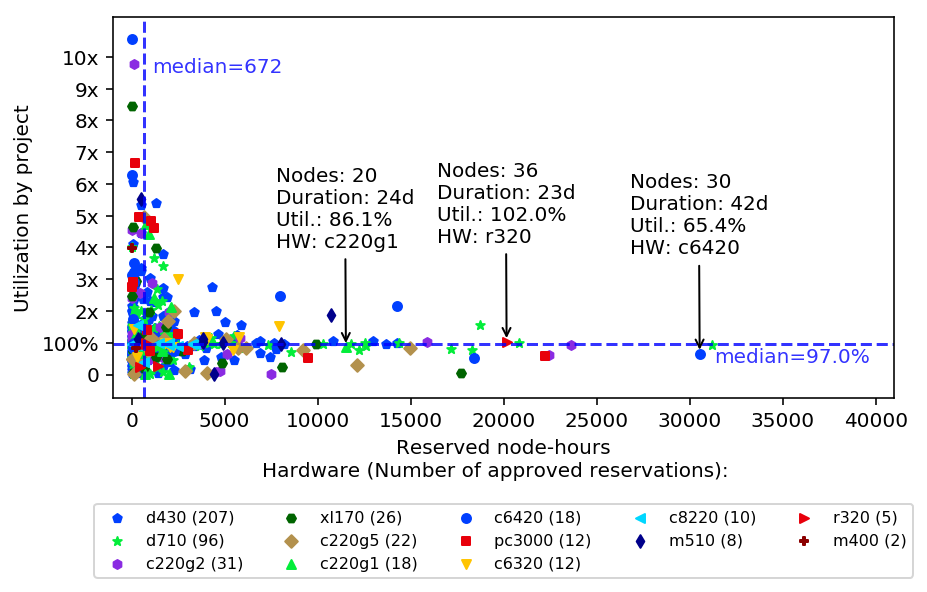

Percent of approved reservations (abs. count: 604) that have positive utilization (abs. count: 483): 79.967


In [23]:
# Visualize utilization estimates

def update_ticks(x, pos):
    if x > 100:
        return str(int(x/100)) + "x"
    elif x==100:
        return str(int(x)) + "%"
    else: 
        return x

res_eval = res_eval_all[res_eval_all.type.isin(major_types.index)]

marker_list = Line2D.filled_markers
marker_list = [x for x in marker_list if x != "8"]

# Assign markers in the order of increasing node count
type_marker = {hw:marker_list[idx % len(marker_list)] 
                for idx, hw in enumerate(major_types.sort_values("count", ascending=True).index)}

positive_usage = res_eval[(res_eval["percent_util"] > 0) & (res_eval["percent_util"] <= 1100)]
display(res_eval[res_eval["percent_util"] > 1100].T)

display(positive_usage.loc[positive_usage.percent_util.idxmax()])

print positive_usage.percent_util.describe()

print "Total number of reservations with positive usage:", len(positive_usage)
fig, ax = plt.subplots(figsize=(7,3.5))
for hw in positive_usage.type.value_counts().index:
     ax.scatter(positive_usage[positive_usage.type==hw].actual_node_hours, 
                positive_usage[positive_usage.type==hw].percent_util, 
                s=20, 
                c = type_cmap[hw], 
                marker = type_marker[hw],
                alpha=1.0, 
                label="%s (%d)" % (hw, len(positive_usage[positive_usage.type==hw])));

nh_med = positive_usage["actual_node_hours"].median()
ax.axvline(x=nh_med, linestyle="--", c="blue", alpha=0.8)
ax.annotate('median=%d' % nh_med, xy=(0,0),
            xytext=(nh_med * 1.6, positive_usage["percent_util"].max() * 0.9), 
            color="blue", alpha=0.8)

util_med = positive_usage["percent_util"].median()
ax.axhline(y=util_med, linestyle="--", c="blue", alpha=0.8)
ax.annotate('median=%.1f%%' % util_med, xy=(0,0),
            xytext=(positive_usage["actual_node_hours"].max()*0.29, util_med * 0.4), 
            color="blue", alpha=0.8)
    
ax.yaxis.set_ticks(range(0, (int(positive_usage["percent_util"].max())/100 + 1) * 100, 100))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
    
ax.set_ylabel("Utilization by project")
ax.set_xlabel("Reserved node-hours")

# Additional labeling for specific large reservations
for idx in ["c085105c-3dbe-11e8-985e-026d7828c80f", 
            "95edaecf-0473-11e8-a5f7-5254000b4f72", 
            "24806cf6-ff0e-11e7-b2cb-021fd9d70c35"]:
    ax.annotate('Nodes: %d\nDuration: %dd\nUtil.: %3.1f%%\nHW: %s' % 
                (int(positive_usage.at[idx, "nodes"]), 
                 (positive_usage.at[idx, "actual_end"]-positive_usage.at[idx, "actual_start"]).days, 
                 positive_usage.at[idx, "percent_util"], positive_usage.at[idx, "type"]),
            xy=(positive_usage.at[idx, "actual_node_hours"], 
                positive_usage.at[idx, "percent_util"]), 
                xycoords='data',
            xytext=(-35, 50), textcoords='offset points', 
                arrowprops=dict(arrowstyle="->"), horizontalalignment='left')
    
# Additional styling
ax.set_xlim([-1000, 41000])
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.375),
           fancybox=True, shadow=False, ncol=5, fontsize = 8)     
ax.annotate('Hardware (Number of approved reservations):', xy=(0,0),
                xytext=(7000, -320), color="black",)    
plt.show()

print "Percent of approved reservations (abs. count: %d) that \
have positive utilization (abs. count: %d): %.3f" % \
(len(res_eval[res_eval.approved==True]), 
 len(res_eval[(res_eval["percent_util"] > 0)]), 
 100.0 * len(res_eval[(res_eval["percent_util"] > 0)]) / len(res_eval[res_eval.approved==True]))

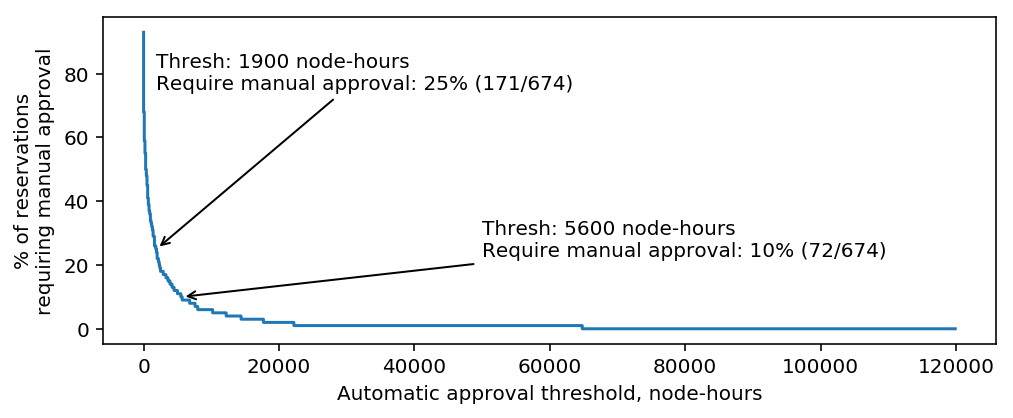

In [24]:
# How many reservations will need to be manually approved for a given node-hours auto-approval thresh?

res_sub = res_eval[res_eval.has_submit == True]

x_vals = range(0, int(res_sub.actual_node_hours.max()), 100)
y_vals = [100 * (len(res_sub[res_sub.actual_node_hours >= x]))/len(res_sub) for x in x_vals]

fig, ax = plt.subplots(figsize=(8,3))
ax.step(x_vals, y_vals)
ax.set_xlabel("Automatic approval threshold, node-hours");
ax.set_ylabel("% of reservations\nrequiring manual approval");

# Visualize specific points
for to_show_y_val in [25,10]:
    y_s = pd.Series(y_vals)
    to_show_idx = y_s[y_s <=to_show_y_val].index[0]
    to_show_x = pd.Series(x_vals).at[to_show_idx]

    xytext_x = 0 if to_show_y_val==25 else 150
    xytext_y = 80 if to_show_y_val==25 else 20
    ax.annotate('Thresh: %.0f node-hours\nRequire manual approval: %d%% (%d/%d)' % 
                (to_show_x, y_s.at[to_show_idx], len(res_sub[res_sub.actual_node_hours >= to_show_x]), len(res_sub)), 
            xy=(pd.Series(x_vals).at[to_show_idx], y_s.at[to_show_idx]), 
            xycoords='data',
            xytext=(xytext_x, xytext_y), textcoords='offset points', arrowprops=dict(arrowstyle="->"), horizontalalignment='left')

## Visualize experiment parameters and reservation parameters side by side

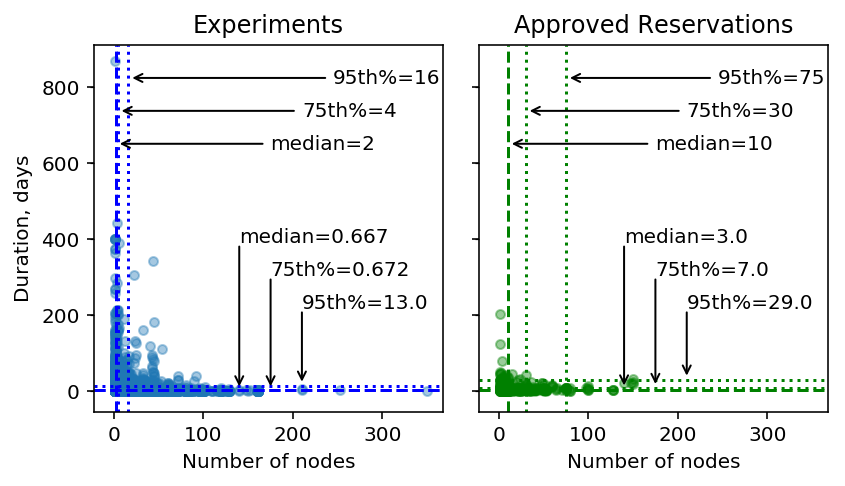

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3.5), sharey=True, sharex=True)

node_df_usage = portal_all_with_hw[~portal_all_with_hw["type"].isin(["pcvm", "vm"])].groupby(["uuid"])['duration'].agg(['count', 'first'])
node_df_usage["duration_d"] = node_df_usage["first"] / (3600*24)

ymax = node_df_usage["duration_d"].max()
xmax = node_df_usage["count"].max()

node_df_usage.plot.scatter(x="count", y="duration_d", alpha=0.4, logx=False, ax = ax1)

nodes_med = node_df_usage["count"].median()
ax1.annotate('median=%d' % nodes_med, xy=(nodes_med,ymax*0.75),
             xytext=(xmax * 0.5, ymax * 0.75),
             arrowprops=dict(arrowstyle="->"), va='center')
ax1.axvline(x=node_df_usage["count"].median(), linestyle="--", c="blue")

nodes_75p = node_df_usage["count"].quantile(0.75)
ax1.annotate('75th%%=%d' % nodes_75p, xy=(nodes_75p, ymax * 0.85),
            xytext=(xmax * 0.6, ymax * 0.85),
            arrowprops=dict(arrowstyle="->"), va='center')
ax1.axvline(nodes_75p, linestyle=":", c="blue")

nodes_95p = node_df_usage["count"].quantile(0.95)
ax1.annotate('95th%%=%d' % nodes_95p, xy=(nodes_95p,ymax*0.95),
             xytext=(xmax * 0.7, ymax * 0.95),
             arrowprops=dict(arrowstyle="->"), va='center')
ax1.axvline(nodes_95p, linestyle=":", c="blue")


duration_d_med = node_df_usage["duration_d"].median()
ax1.axhline(y=duration_d_med, linestyle="--", c="blue")
ax1.annotate('', xy=(xmax*0.4,duration_d_med),
                  xytext=(xmax * 0.4, ymax * 0.45),
            arrowprops=dict(arrowstyle="->"), va='bottom', ha='left')
ax1.annotate('median=%.3f' % duration_d_med, xy=(xmax*0.4,duration_d_med),
                  xytext=(xmax * 0.4, ymax * 0.45))

duration_d_75p = node_df_usage["duration_d"].quantile(0.75)
ax1.axhline(y=duration_d_75p, linestyle=":", c="blue")
ax1.annotate('', xy=(xmax*0.5,duration_d_75p),
                  xytext=(xmax * 0.5, ymax * 0.35),
            arrowprops=dict(arrowstyle="->"), va='bottom', ha='left')
ax1.annotate('75th%%=%0.3f' % duration_d_75p, xy=(xmax*0.5,duration_d_75p),
                  xytext=(xmax * 0.5, ymax * 0.35))

duration_d_95p = node_df_usage["duration_d"].quantile(0.95)
ax1.axhline(y=duration_d_95p, linestyle=":", c="blue")
ax1.annotate('', xy=(xmax*0.6,duration_d_95p),
                  xytext=(xmax*0.6, ymax * 0.25),
            arrowprops=dict(arrowstyle="->"), va='bottom', ha='center')
ax1.annotate('95th%%=%0.1f' % duration_d_95p, xy=(xmax*0.6,duration_d_95p),
                  xytext=(xmax*0.6, ymax * 0.25))

ax1.set_ylabel("Duration, days")
ax1.set_xlabel("Number of nodes")
ax1.set_title("Experiments")

to_plot = positive_usage[positive_usage["approved"]==True]

to_plot.plot.scatter(x="nodes", y="duration_d", c="green", alpha=0.4, ax=ax2)

nodes_med = to_plot.nodes.median()
ax2.axvline(x=nodes_med, linestyle="--", c="green")
ax2.annotate('median=%d' % nodes_med, xy=(nodes_med, ymax*0.75),
             xytext=(xmax * 0.5, ymax * 0.75),
             arrowprops=dict(arrowstyle="->"), va='center')

nodes_75p = to_plot.nodes.quantile(.75)
ax2.axvline(x=nodes_75p, linestyle=":", c="green")
ax2.annotate('75th%%=%d' % nodes_75p, xy=(nodes_75p, ymax * 0.85),
             xytext=(xmax * 0.6, ymax * 0.85),
             arrowprops=dict(arrowstyle="->"), va='center')

nodes_95p = to_plot.nodes.quantile(.95)
ax2.axvline(x=nodes_95p, linestyle=":", c="green")
ax2.annotate('95th%%=%d' % nodes_95p, xy=(nodes_95p, ymax * 0.95),
             xytext=(xmax * 0.7, ymax * 0.95),
             arrowprops=dict(arrowstyle="->"), va='center')

duration_d_med = to_plot["duration_d"].median()
ax2.axhline(y=duration_d_med, linestyle="--", c="green")
ax2.annotate('', xy=(xmax*0.4,duration_d_med),
                  xytext=(xmax * 0.4, ymax * 0.45),
            arrowprops=dict(arrowstyle="->"), va='bottom', ha='left')
ax2.annotate('median=%.1f' % duration_d_med, xy=(xmax*0.4,duration_d_med),
                  xytext=(xmax * 0.4, ymax * 0.45))

duration_d_75p = to_plot["duration_d"].quantile(0.75)
ax2.axhline(y=duration_d_75p, linestyle=":", c="green")
ax2.annotate('', xy=(xmax*0.5,duration_d_75p),
                  xytext=(xmax * 0.5, ymax * 0.35),
            arrowprops=dict(arrowstyle="->"), va='bottom', ha='left')
ax2.annotate('75th%%=%0.1f' % duration_d_75p, xy=(xmax*0.5,duration_d_75p),
                  xytext=(xmax * 0.5, ymax * 0.35))

duration_d_95p = to_plot["duration_d"].quantile(0.95)
ax2.axhline(y=duration_d_95p, linestyle=":", c="green")
ax2.annotate('', xy=(xmax*0.6,duration_d_95p),
                  xytext=(xmax*0.6, ymax * 0.25),
            arrowprops=dict(arrowstyle="->"), va='bottom', ha='center')
ax2.annotate('95th%%=%0.1f' % duration_d_95p, xy=(xmax*0.6,duration_d_95p),
                  xytext=(xmax*0.6, ymax * 0.25))

ax2.set_xlabel("Number of nodes")
ax2.set_title("Approved Reservations")

plt.tight_layout()

## Usage of profiles

In [26]:
# Add special record for the original OpenStack-130 (to catch usage before renaming)
if not "Openstack-Original-130" in profiles.name.unique():
    profiles = pd.concat([profiles,
                         pd.DataFrame([{"name": "Openstack-Original-130", "profileid": 130}], index=[8888])],
                         sort=True)

print "Number of profiles: %d, number of unique profile IDs: %d" % (len(profiles), len(profiles["profileid"].unique()))

profile_names = profiles[["profileid", "name"]].rename(index=str, 
                                                       columns={"profileid": "profile_id", "name": "profile_name"})

portal_profiles = portal_all.merge(profile_names, how="left")

portal_profiles.profile_name.isnull().value_counts()

portal_profiles["node_hours"] = portal_profiles["physnode_count_x"] * portal_profiles["duration"] / 3600.0

print "Stats for node-hours:\n", portal_profiles.node_hours.describe()

Number of profiles: 9016, number of unique profile IDs: 9016
Stats for node-hours:
count     94489.000000
mean        218.762363
std        2017.815335
min           0.000000
25%           1.920000
50%          16.053611
75%          64.057778
max      213249.450556
Name: node_hours, dtype: float64


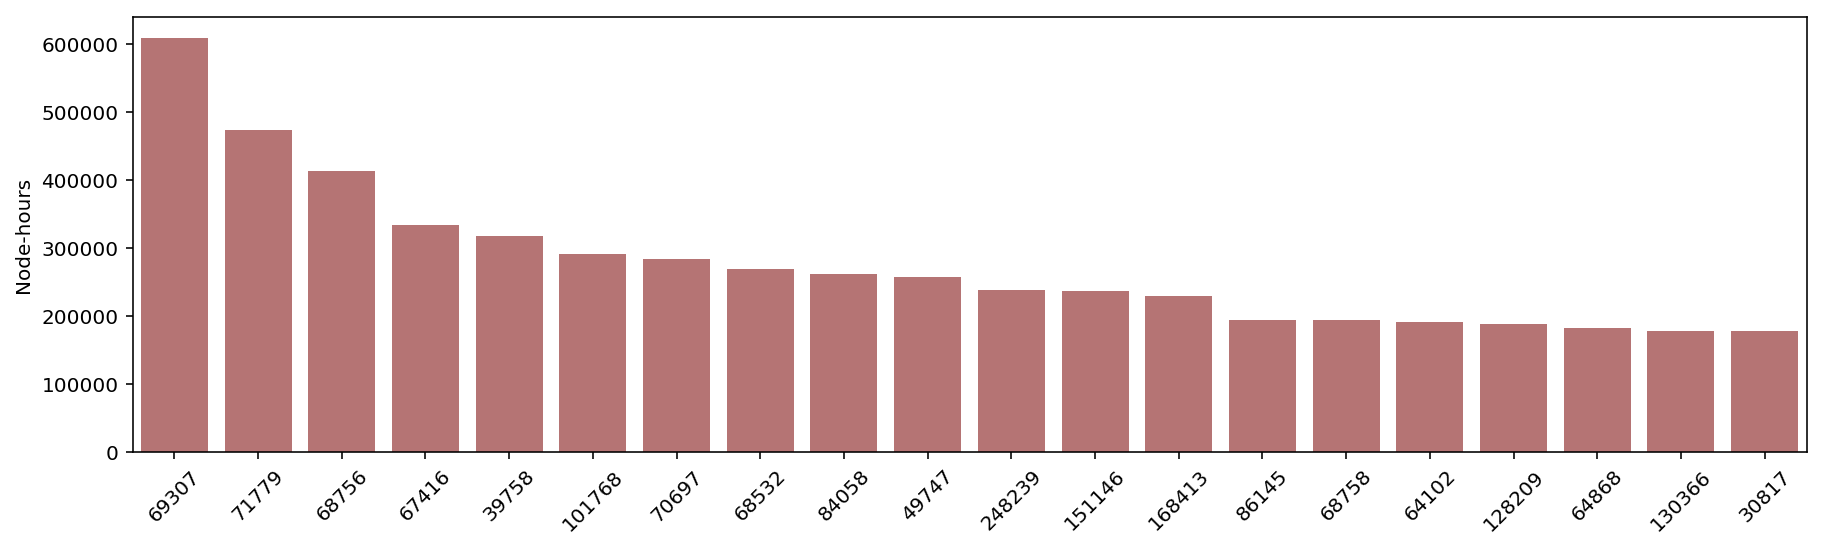

In [27]:
creator_nodehours = portal_profiles.groupby(['creator_idx'])[["node_hours"]].sum().sort_values(
    "node_hours", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x=range(len(creator_nodehours.index)), y=creator_nodehours["node_hours"].tolist(), 
            color="brown", alpha=0.7, ax=ax);
ax.set_ylabel("Node-hours")
ax.xaxis.set_ticklabels(creator_nodehours.index);
plt.xticks(rotation=45);

In [28]:
# Ispect Openstack profiles, old and new

print len(portal_profiles[portal_profiles["profile_id"] == 130])
print portal_profiles[portal_profiles["profile_id"] == 130]["uuid"].sample(5)

print portal_profiles[portal_profiles["profile_id"] == 130]["created"].min()
print portal_profiles[portal_profiles["profile_id"] == 130]["created"].max()

for p in [7702, 7704, 130]:
    print "Profile id: %d, # of experiments: %d" % (p, len(portal_profiles[portal_profiles["profile_id"] == p]))
    print "\t", portal_profiles[portal_profiles["profile_id"] == p]["profile_name"].unique()
    print "\t", db["apt_profile_versions"][db["apt_profile_versions"]["profileid"]==p]["version"].unique()
    print "\t", portal_profiles[portal_profiles["profile_id"] == p]["node_hours"].sum()
    print "\t", portal_profiles[portal_profiles["profile_id"] == p]["created"].min(), "--", portal_profiles[portal_profiles["profile_id"] == p]["destroyed"].max()

5969
19151    b79d4906-4a00-11e6-ac8a-90e2ba22fee4
12210    a4ce1eb7-dbf4-11e5-b570-99cadac50270
22652    0d9c2425-8283-11e6-ac8c-90e2ba22fee4
27181    dd99343c-b808-11e6-ac8c-90e2ba22fee4
4172     59565691-5af7-11e5-bf03-38eaa71273fa
Name: uuid, dtype: object
2015-06-04 12:31:48
2017-12-20 08:21:35
Profile id: 7702, # of experiments: 79
	['0D825EF7A8']
	[0]
	75585.60333333332
	2017-12-20 10:07:36 -- 2018-06-20 08:40:25
Profile id: 7704, # of experiments: 4232
	['BFEF09DAB6']
	[0]
	1143644.7469444443
	2017-12-20 10:06:29 -- 2019-04-23 13:04:45
Profile id: 130, # of experiments: 5969
	['Openstack-Original-130']
	[ 8  1  0  2  3  5  4  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
	1465565.413888889
	2015-06-04 12:31:48 -- 2018-01-17 00:19:34


In [29]:
# Estimate monthly usage, both in terms of total node-hours and number of profiles used

def seconds_until_end_of_month(curr):
    end_of_month = dt.datetime(year=curr.year, 
                               month=curr.month, 
                               day=calendar.monthrange(curr.year, curr.month)[1],
                               hour=23, 
                               minute=59, 
                               second=59)
    return (end_of_month - curr).total_seconds() + 1
    
prof_uniq_names = portal_profiles["profile_name"].unique()

y_m = sorted(set(portal_profiles["created"].apply(lambda x: dt.datetime(year=x.year, 
                                                                            month=x.month, day=15)).unique()).union(
set(portal_profiles["destroyed"].apply(lambda x: dt.datetime(year=x.year, 
                                                                 month=x.month, day=15)).unique())))

y_m_trimmed = [str(x)[:7] for x in y_m]

monthly_usage = pd.DataFrame(0, index=np.arange(len(prof_uniq_names)), columns=y_m_trimmed).set_index(prof_uniq_names)

nh_error = 0

for idx, row in portal_profiles.iterrows():
    
    ctime = str(row["created"])[:7]
    dtime = str(row["destroyed"])[:7]
    r = row["profile_name"]
    nh = row["node_hours"]
    node_count = row["physnode_count_x"]
    
    #print row["created_timestamp"], "---", row["destroyed_timestamp"]
    
    if ctime == dtime:
        # Created and destroyed in the same year-month
        monthly_usage.loc[r, ctime] += nh
    else:
        curr_t = row["created"]
        curr_nh = seconds_until_end_of_month(curr_t) * node_count / 3600.0
        monthly_usage.loc[r, ctime] += curr_nh
        nh -= curr_nh
        
        # Set curr_t to the beginning of the following month
        curr_t = dt.datetime(year=curr_t.year, 
                             month=curr_t.month, 
                             day=1,
                             hour=0, 
                             minute=0, 
                             second=0) + relativedelta(months=1)
        
        while True:
            if curr_t.month < 10: 
                curr_t_str = "%d-0%d" % (curr_t.year, curr_t.month)
            else:  
                curr_t_str = "%d-%d" % (curr_t.year, curr_t.month)
            
            if curr_t_str == dtime:
                break
            
            curr_nh = seconds_until_end_of_month(curr_t) * node_count / 3600.0
            monthly_usage.loc[r, curr_t_str] += curr_nh
            nh -= curr_nh
            
            curr_t += relativedelta(months=1)
            
        # Handle last incomplete month
        curr_nh = (row["destroyed"] - curr_t).total_seconds() * node_count / 3600.0
        monthly_usage.loc[r, curr_t_str] += curr_nh
        
        nh_error += abs(nh - curr_nh)

print "Estimated node-hour error:", nh_error  

# Exclude nan
monthly_usage = monthly_usage[~monthly_usage.index.isnull()]

display(monthly_usage.sample(5))

print "Number of profiles summarized in monthly_usage dataframe:", len(monthly_usage)

mus = monthly_usage.sum(axis=0)
print "mus Series: monthly total usage in node-hours is calculated."

muc = monthly_usage.fillna(0).astype(bool).sum(axis=0)
print "muc Series: monthly number of profiles with non-zero usage is calculated."

Estimated node-hour error: 5.31713197777e-10


,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,...,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
15564FF49A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3B1C1E9557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
82022CFB6C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9E84526137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
FE94889D23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.102222,0.0,0.0,0.0


Number of profiles summarized in monthly_usage dataframe: 6906
mus Series: monthly total usage in node-hours is calculated.
muc Series: monthly number of profiles with non-zero usage is calculated.


## Visualize monthly metrics

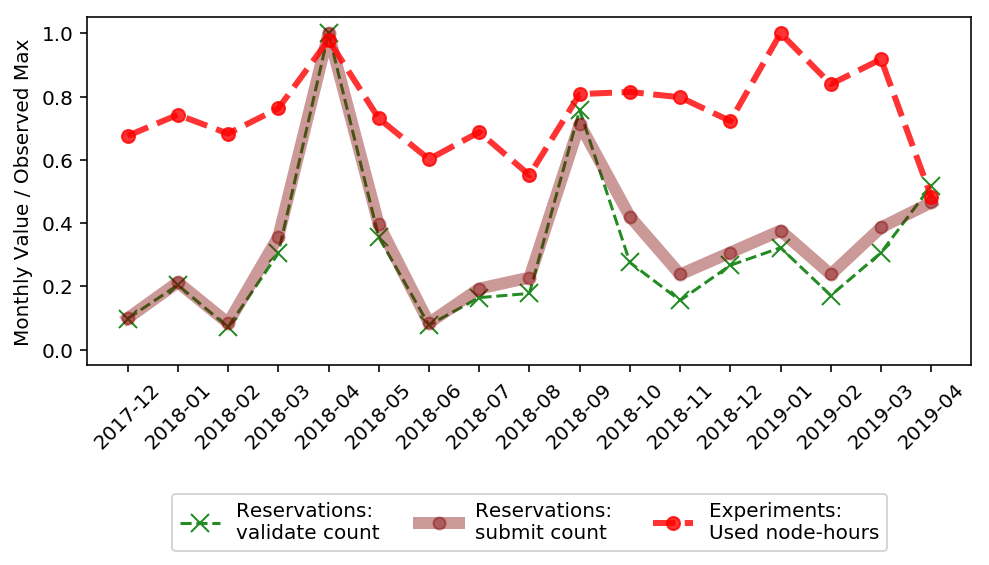

In [30]:
v_month_counts = pd.DataFrame(res[res.action=="validate"].timestamp.dt.to_period('M').value_counts())
v_month_counts = v_month_counts.sort_index()
v_month_counts.columns = ["Validate count"]

s_month_counts = pd.DataFrame(res[res.action=="submit"].timestamp.dt.to_period('M').value_counts())
s_month_counts = s_month_counts.sort_index()
s_month_counts.columns = ["Submit count"]

month_counts = v_month_counts.join(s_month_counts)

month_counts.index = [str(x) for x in month_counts.index]
month_counts = month_counts.join(pd.DataFrame(mus/mus.max(), columns=["Used node-hours"]))

#month_counts = month_counts[month_counts.index<"2018-12"]

#display(month_counts)

fig, ax = plt.subplots(1, sharey=True, figsize=(7, 4.5));

ax.plot(range(len(month_counts)), 
        month_counts["Validate count"]/month_counts["Validate count"].max(), '--x',
            color="forestgreen", alpha=1.0, linewidth=1.5, markersize=9, label="Reservations:\nvalidate count")
ax.plot(range(len(month_counts)), 
        month_counts["Submit count"]/month_counts["Submit count"].max(), '-o',
            color="maroon", alpha=0.40, linewidth=6, markersize=6, label="Reservations:\nsubmit count")
ax.plot(range(len(month_counts)), 
          month_counts["Used node-hours"], '--o', linewidth=3,
              color="red", alpha=0.8, markersize=6.5, label="Experiments:\nUsed node-hours")

# Additional styling
ax.set_ylabel("Monthly Value / Observed Max")
ax.xaxis.set_ticks(range(len(month_counts)))
ax.xaxis.set_ticklabels(month_counts.index)
plt.xticks(rotation=45);
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.45),
           fancybox=True, shadow=False, ncol=3, fontsize = 10) 
ax.set_ylim([-0.05,1.05])
plt.tight_layout()

res_active_months = month_counts.index

In [31]:
# Show monthly stats for specific months

res_appr = res_eval[res_eval.approved==True]

r1 = res_appr[res_appr.actual_start.dt.to_period('M').astype("string")=="2018-01"].actual_node_hours.sum()
print "Node-hours in approved reservations in Jan 2018:",r1 
e1 = mus["2018-01"]
print "Node-hours in all experiments in Jan 2018:", e1
print "Former as percent of the latter:", r1 / e1 * 100

print "---"

r4 = res_appr[res_appr.actual_start.dt.to_period('M').astype("string")=="2018-04"].actual_node_hours.sum()
print "Node-hours in approved reservations in Apr 2018:",r4
e4 = mus["2018-04"]
print "Node-hours in all experiments in Apr 2018:", e4
print "Former as percent of the latter:", r4 / e4 * 100

Node-hours in approved reservations in Jan 2018: 53818.707777777774
Node-hours in all experiments in Jan 2018: 539714.0286111113
Former as percent of the latter: 9.971708150013017
---
Node-hours in approved reservations in Apr 2018: 134655.62194444443
Node-hours in all experiments in Apr 2018: 711764.5494444446
Former as percent of the latter: 18.918562613092703


In [32]:
# Prepare usage heatmap for popular profiles as a dataframe

# Aggregate big OpenStack profiles (the ones that should be considered the same)
monthly_usage_to_plot = monthly_usage.copy() 

#monthly_usage_to_plot.loc["OpenStack"] = monthly_usage_to_plot.loc[["OpenStack-legacy", "OpenStack", "Openstack-Original-130"]].sum(axis=0)
#monthly_usage_to_plot.drop(["OpenStack-legacy", "Openstack-Original-130"], inplace=True)

# Heatmap will show n + 1 (last one is <OTHER>) profiles/colors
n = 41
total_profile_usage = monthly_usage_to_plot.sum(axis=1).sort_values(ascending=False)
popular_profiles = total_profile_usage[:n-1]
popular_usage = monthly_usage_to_plot.loc[popular_profiles.index]
popular_usage.loc["<OTHER>"] = mus - popular_usage.sum(axis=0)
popular_usage = popular_usage.divide(mus, axis=1).T

#popular_usage = popular_usage[popular_usage.index >= '2015-05']
#popular_usage = popular_usage[popular_usage.index < '2018-12']

#popular_usage.index = popular_usage.index.astype("string")
display(popular_usage.sample(5))

colors = plt.cm.nipy_spectral(np.linspace(0, 1, n))
# Use gray for OTHER
colors[-1] = (0.8274509803921568, 0.8274509803921568, 0.8274509803921568, 1.0)

month_labels_idx = range(len(popular_usage))
month_labels = popular_usage.index.tolist()
popular_usage.index = month_labels_idx 

,Openstack-Original-130,BFEF09DAB6,A4734D6B47,BE8AE3E890,9B8B0234D6,E7233AB25D,9DD0B0D4DB,FE253E47DF,0620352F71,DE65737140,...,CB6EB3A100,6A26CBAEE5,0D825EF7A8,A44443CF65,BD66C21DAC,71323406D9,F1F82828E9,0ACD84555F,79B9E7B884,<OTHER>
2016-04,0.186892,0.000000,0.066824,0.000000,0.005493,0.000000,0.000000,0.0,0.065357,0.030763,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.037915,0.548757
2018-05,0.000000,0.160752,0.000000,0.072813,0.007767,0.000000,0.010980,0.0,0.000000,0.000000,...,0.000000,0.0,0.029288,0.001516,0.006629,0.007106,0.007869,0.002033,0.000000,0.645147
2017-02,0.096780,0.000000,0.070297,0.000000,0.003087,0.075569,0.040103,0.0,0.000000,0.022871,...,0.010121,0.0,0.000000,0.000000,0.005267,0.003684,0.002459,0.000000,0.000000,0.471362
2017-03,0.101126,0.000000,0.065558,0.000000,0.018183,0.070475,0.028855,0.0,0.000000,0.000000,...,0.018620,0.0,0.000000,0.000000,0.004633,0.003929,0.001880,0.000000,0.000000,0.539166
2017-09,0.099370,0.000000,0.039462,0.067201,0.002657,0.028431,0.022172,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.005169,0.003290,0.005552,0.021622,0.000000,0.578404


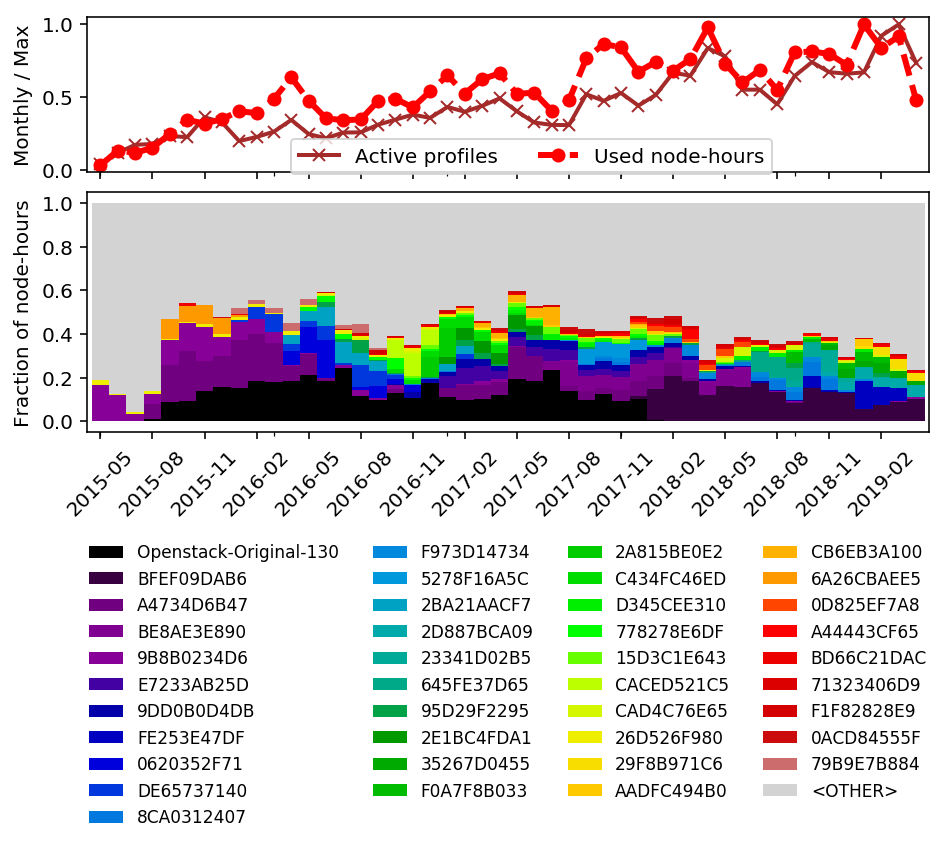

In [33]:
# Show usage heatmap along with node-hours and non-zero profile counts

# This code needs to use real profile names; hashes make this plot useless

fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=True, sharey=False, 
        gridspec_kw={'height_ratios':[2.0,3.1]}, figsize=(7,6.0))

# mus = mus[mus.index >= '2015-05']
# mus = mus[mus.index <= '2018-11']
# muc = muc[muc.index >= '2015-05']
# muc = muc[muc.index <= '2018-11']

#fig.suptitle('Node-Hours: Total Number and Distribution', fontsize=14)

(muc/muc.max()).plot(kind='line', style='-x', ax=axes[0], lw=2, color="brown", logy=False, label="Active profiles");
(mus/mus.max()).plot(kind='line', style='--o', ax=axes[0], lw=3, color="red", logy=False, label="Used node-hours");
axes[0].set_ylabel("Monthly / Max");
axes[0].legend(bbox_to_anchor=(0.23, 0.28), ncol=2);

#display(popular_usage)
popular_usage.plot(kind='bar', stacked=True, width = 1.0, ax=axes[1], 
                     color=colors);

# Shrink current axis's height by 10% on the bottom
box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9]);

# Additional styling
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=False, shadow=False, frameon=False, 
          ncol=4, fontsize=8.5);
axes[1].set_ylabel("Fraction of node-hours")
axes[1].set_ylim([-0.05,1.05])
axes[1].xaxis.set_ticks(month_labels_idx[::3])
axes[1].xaxis.set_ticklabels(month_labels[::3])
plt.xticks(rotation=45);
plt.tight_layout(h_pad=0.2)

## Track the changes related to introduction of reservations

In [34]:
res_started = positive_usage.actual_start.min()
print "The first approved reservation started on:", res_started

The first approved reservation started on: 2017-12-08 14:00:00


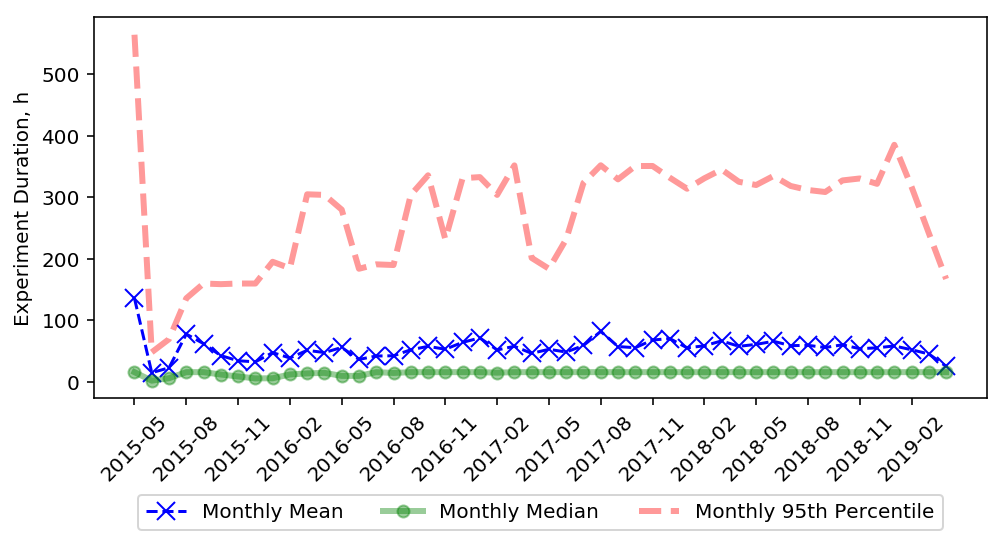

In [35]:
# Estimate and visualize monthly medians for duration of experiments 
    
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_    
    
monthly_stats = portal_all_with_hw_major[["uuid", "created", "duration", "physnode_count_x"]].copy()
monthly_stats.drop_duplicates(["uuid"], inplace = True)
monthly_stats['mnth_yr'] = monthly_stats.created.dt.to_period('M')
#monthly_stats.head().T

monthly_stats = monthly_stats.groupby(["mnth_yr"])['duration'].agg([np.mean, np.median, percentile(95)])
monthly_stats = monthly_stats / 3600.0

fig, ax = plt.subplots(1, sharey=True, figsize=(8, 3.5));

ax.plot(range(len(monthly_stats)), 
        monthly_stats["mean"], '--x',
        color="blue", alpha=1.0, linewidth=1.5, markersize=9, label="Monthly Mean")
ax.plot(range(len(monthly_stats)), 
        monthly_stats["median"], '-o',
        color="green", alpha=0.40, linewidth=3, markersize=6, label="Monthly Median")
ax.plot(range(len(monthly_stats)), 
        monthly_stats["percentile_95"], '--',
        color="red", alpha=0.40, linewidth=3, markersize=6, label="Monthly 95th Percentile")

# Additional styling
ax.xaxis.set_ticks(range(len(monthly_stats))[::3])
ax.xaxis.set_ticklabels(monthly_stats.index[::3])
plt.xticks(rotation=45);
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
           fancybox=True, shadow=False, ncol=3, fontsize = 10);
ax.set_ylabel("Experiment Duration, h");

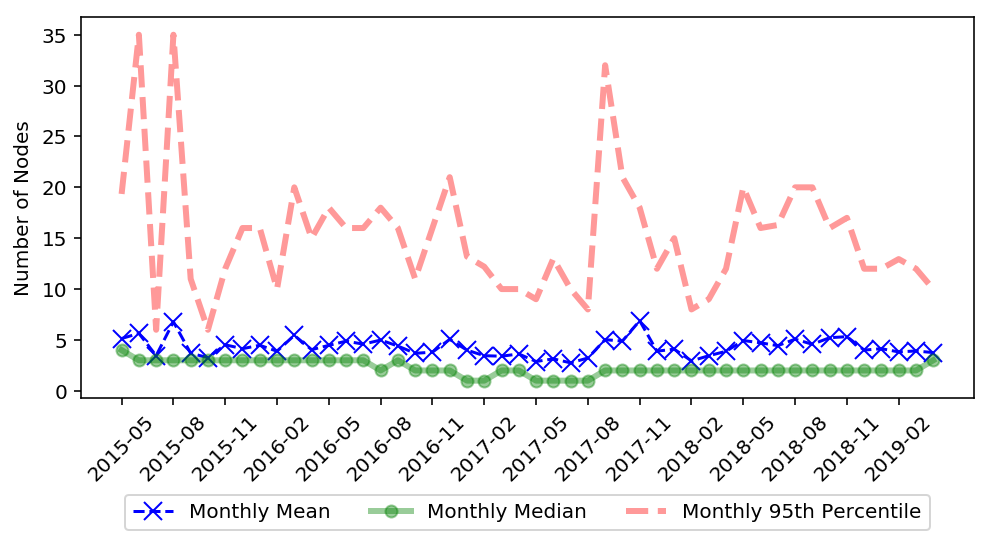

In [36]:
# Estimate and visualize monthly medians for size of experiments    
    
monthly_stats = portal_all_with_hw_major[["uuid", "created", "duration", "physnode_count_x"]].copy()
monthly_stats.drop_duplicates(["uuid"], inplace = True)
monthly_stats['mnth_yr'] = monthly_stats.created.dt.to_period('M')
#monthly_stats.head().T

monthly_stats = monthly_stats.groupby(["mnth_yr"])['physnode_count_x'].agg([np.mean, np.median, percentile(95)])

fig, ax = plt.subplots(1, sharey=True, figsize=(8, 3.5));

ax.plot(range(len(monthly_stats)), 
        monthly_stats["mean"], '--x',
        color="blue", alpha=1.0, linewidth=1.5, markersize=9, label="Monthly Mean")
ax.plot(range(len(monthly_stats)), 
        monthly_stats["median"], '-o',
        color="green", alpha=0.40, linewidth=3, markersize=6, label="Monthly Median")
ax.plot(range(len(monthly_stats)), 
        monthly_stats["percentile_95"], '--',
        color="red", alpha=0.40, linewidth=3, markersize=6, label="Monthly 95th Percentile")

# Additional styling
ax.xaxis.set_ticks(range(len(monthly_stats))[::3])
ax.xaxis.set_ticklabels(monthly_stats.index[::3])
plt.xticks(rotation=45);
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
           fancybox=True, shadow=False, ncol=3, fontsize = 10);
ax.set_ylabel("Number of Nodes");